In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
from glob import glob
import time
import os
import ops
from ops import *
from utils import *
import cv2
from os.path import join
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = './img_align_celeba/img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM = 100                                        # Dimension of face's manifold
GENERATOR_DENSE_SIZE = 64*8                        # Length of first tensor in generator

IMAGE_SIZE = 64                                    # Shapes of input image
BATCH_SIZE = 64                                    # Batch size
N_CHANNELS = 3                                     # Number channels of input image

MERGE_X = 8                                        # Number images in merged image
MERGE_Y = 8

In [3]:
assert(os.path.exists(DATA_PATH)), \
    'Please download aligned celebA (https://www.kaggle.com/jessicali9530/celeba-dataset/) to DATA_PATH folder'

In [4]:
#center crop to 150*120 and resize to 64,64 the images to make them more manageable
def crop_and_scale(img):
    cropped_img=img[34:184,29:149]
    return cv2.resize(cropped_img,(64,64))

In [5]:
def visualize_samples(data_path, n_cols=5, n_rows=2, crop=False):
    """Visualize samples."""
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n,img_name in enumerate(np.random.choice(os.listdir(data_path), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img = plt.imread(join(data_path,img_name))
        plt.title(img_name)
        if crop:
            plt.imshow(crop_and_scale(img))
        else:
            plt.imshow(img)             
    plt.show()

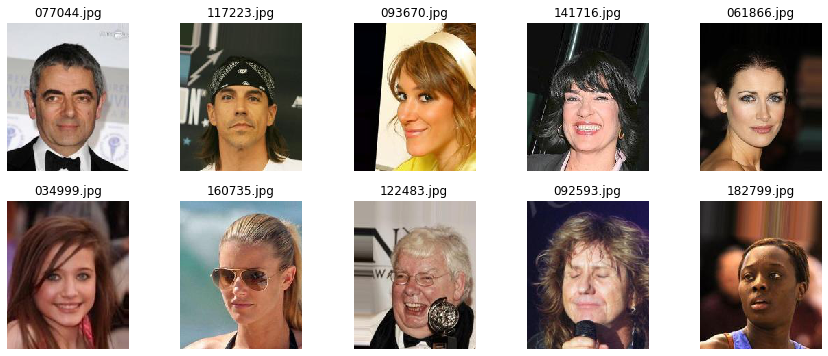

In [6]:
visualize_samples(DATA_PATH)

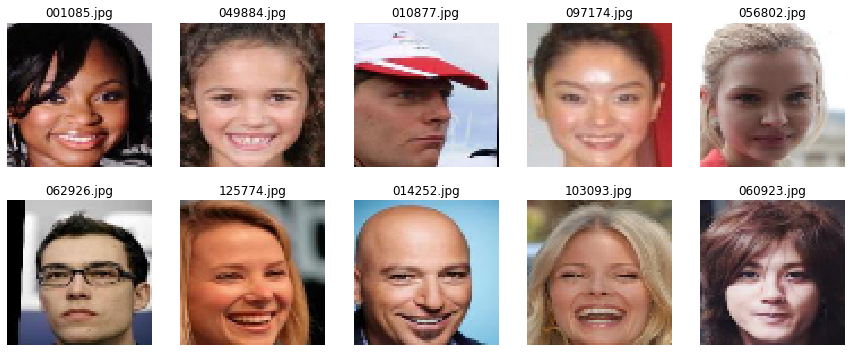

In [7]:
visualize_samples(DATA_PATH, crop = True)

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

Reference: https://github.com/carpedm20/DCGAN-tensorflow

In [8]:
tf.keras.backend.clear_session()

In [ ]:
#g_bn0 = batch_norm(name='g_bn0')
#g_bn1 = batch_norm(name='g_bn1')
#g_bn2 = batch_norm(name='g_bn2')
#g_bn3 = batch_norm(name='g_bn3')

#def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
#    Dxy = IMAGE_SIZE // 16
#    z_ = linear(z, GENERATOR_DENSE_SIZE * Dxy * Dxy, 'g_h0_lin')
#    h_in = tf.reshape(z_, [-1, Dxy, Dxy, GENERATOR_DENSE_SIZE])
    
#    h0 = tf.nn.relu(g_bn0(h_in, is_training))
    # CONV1
#    h1 = deconv2d(h0, [BATCH_SIZE, IMAGE_SIZE // 8, IMAGE_SIZE // 8, GENERATOR_DENSE_SIZE // 2], name='g_h1')
#    h1 = tf.nn.relu(g_bn1(h1, is_training))
    # CONV2
#    h2 = deconv2d(h1, [BATCH_SIZE, IMAGE_SIZE // 4, IMAGE_SIZE // 4, GENERATOR_DENSE_SIZE // 4], name='g_h2')
#    h2 = tf.nn.relu(g_bn2(h2, is_training))
    # CONV3
#    h3 = deconv2d(h2, [BATCH_SIZE, IMAGE_SIZE // 2, IMAGE_SIZE // 2, GENERATOR_DENSE_SIZE // 8], name='g_h3')
#    h_prev = tf.nn.relu(g_bn3(h3, is_training))

#    h_out = deconv2d(h_prev, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name='g_out')

#    return tf.nn.tanh(h_out)

In [9]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    Dxy = IMAGE_SIZE // 16
    z_ = linear(z, GENERATOR_DENSE_SIZE * Dxy * Dxy, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, Dxy, Dxy, GENERATOR_DENSE_SIZE])
     
    g_batch_norm_0 = batch_norm(name='g_batch_norm_0')
    h_0_a = tf.nn.relu(g_batch_norm_0(h_in, is_training), name='g_lr_0')
     
    # DE-CONV1    
    h_1 = deconv2d(h_0_a, output_shape=[BATCH_SIZE, IMAGE_SIZE // 8, IMAGE_SIZE // 8, GENERATOR_DENSE_SIZE // 2], 
                   name='g_deconv2d_1')
    g_batch_norm_1 = batch_norm(name='g_batch_norm_1')
    h_1_a = tf.nn.relu(g_batch_norm_1(h_1, is_training), name='g_lr_1')
    h_1_a_dr = tf.nn.dropout(h_1_a, 0.5, name='g_dr_1')
    
    # DE-CONV2
    h_2 = deconv2d(h_1_a_dr, output_shape=[BATCH_SIZE, IMAGE_SIZE // 4, IMAGE_SIZE // 4, GENERATOR_DENSE_SIZE // 4], 
                   name='g_deconv2d_2')
    g_batch_norm_2 = batch_norm(name='g_batch_norm_2')
    h_2_a = tf.nn.relu(g_batch_norm_2(h_2, is_training), name='g_lr_2')
    h_2_a_dr = tf.nn.dropout(h_2_a, 0.5, name='g_dr_2')
    
    # DE-CONV3
    h_3 = deconv2d(h_2_a_dr, output_shape=[BATCH_SIZE, IMAGE_SIZE // 2, IMAGE_SIZE // 2, GENERATOR_DENSE_SIZE // 8], 
                       name='g_deconv2d_3')
    g_batch_norm_3 = batch_norm(name='g_batch_norm_3')
    h_3_a = tf.nn.relu(g_batch_norm_3(h_3, is_training), name='g_lr_3')  
    
    h_out = deconv2d(h_3_a, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [ ]:
# Batch normalization: to deal with poor initialization and help gradient flow.
#d_bn1 = batch_norm(name='d_bn1')
#d_bn2 = batch_norm(name='d_bn2')
#d_bn3 = batch_norm(name='d_bn3')

#def discriminator(image, is_training, batch_norms=None):
#    df_dim = IMAGE_SIZE # 64
#    h0 = lrelu(conv2d(image, df_dim, name='d_h0_conv'))
    
#    if batch_norms:
#        h1 = lrelu(d_bn1(conv2d(h0, df_dim*2, name='d_h1_conv')))
#        h2 = lrelu(d_bn2(conv2d(h1, df_dim*4, name='d_h2_conv')))
#        h3 = lrelu(d_bn3(conv2d(h2, df_dim*8, name='d_h3_conv')))
#    else:
#        h1 = lrelu(conv2d(h0, df_dim*2, name='d_h1_conv'))
#        h2 = lrelu(conv2d(h1, df_dim*4, name='d_h2_conv'))
#        h3 = lrelu(conv2d(h2, df_dim*8, name='d_h3_conv'))
    
#    linear_out = linear(tf.reshape(h3, [-1, BATCH_SIZE]), 1, 'd_h4_lin')
   
#    return tf.nn.sigmoid(linear_out), linear_out

In [10]:
def discriminator(image, is_training, batch_norms=None):
    
    h_0 = lrelu(conv2d(image, output_dim = IMAGE_SIZE, name='d_conv2d_0'))
    
    if batch_norms:
        d_batch_norm_0 = batch_norm(name='d_batch_norm_0') 
        h_0_a = lrelu(d_batch_norm_0(h_0, is_training), name='d_lr_b0')
        #h_0_p = tf.compat.v1.layers.average_pooling2d(h_0_a, pool_size=(2, 2), strides=2, name='d_pool_0')
    
        h_1 = conv2d(h_0_a, output_dim = IMAGE_SIZE*2, name='d_conv2d_b1')
        d_batch_norm_1 = batch_norm(name='d_batch_norm_1')
        h_1_a = lrelu(d_batch_norm_1(h_1, is_training), name='d_lr_b1')
        #h_1_p = tf.compat.v1.layers.average_pooling2d(h_1_a, pool_size=(2, 2), strides=2, name='d_pool_1')
        
        h_2 = conv2d(h_1_a, output_dim = IMAGE_SIZE*4, name='d_conv2d_b2')
        d_batch_norm_2 = batch_norm(name='d_batch_norm_2') 
        h_2_a = lrelu(d_batch_norm_2(h_2, is_training), name='d_lr_b2')
        #h_2_p = tf.compat.v1.layers.average_pooling2d(h_2_a, pool_size=(2, 2), strides=2, name='d_pool_2')
        
        h_3 = conv2d(h_2_a, output_dim = IMAGE_SIZE*8, name='d_conv2d_b3')
        d_batch_norm_3 = batch_norm(name='d_batch_norm_3') 
        h_3_a = lrelu(d_batch_norm_3(h_3, is_training), name='d_lr_b3')
        #h_3_p = tf.compat.v1.layers.average_pooling2d(h_3_a, pool_size=(2, 2), strides=2, name='d_pool_3')
    
    else:
        h_0_a = lrelu(h_0, name='d_lr_0')
        #h_0_p = tf.compat.v1.layers.average_pooling2d(h_0_a, pool_size=(2, 2), strides=2, name='d_pool_0')
        
        h_1 = conv2d(h_0_a, output_dim = IMAGE_SIZE*2, name='d_conv2d_1')
        h_1_a = lrelu(h_1, name='d_lr_1')
        #h_1_p = tf.compat.v1.layers.average_pooling2d(h_1_a, pool_size=(2, 2), strides=2, name='d_pool_1')
        
        h_2 = conv2d(h_1_a, output_dim = IMAGE_SIZE*4, name='d_conv2d_2')
        h_2_a = lrelu(h_2, name='d_lr_2')
        #h_2_p = tf.compat.v1.layers.average_pooling2d(h_2_a, pool_size=(2, 2), strides=2, name='d_pool_2')
        
        h_3 = conv2d(h_2_a, output_dim = IMAGE_SIZE*8, name='d_conv2d_3')
        h_3_a = lrelu(h_3, name='d_lr_2')
        #h_3_p = tf.compat.v1.layers.average_pooling2d(h_3_a, pool_size=(2, 2), strides=2, name='d_pool_3')
    
    #h_flat = tf.layers.flatten(h_2_p)
    #h_linear = linear(h_flat, IMAGE_SIZE*8, 'd_h_linear')
    #h_linear_a = lrelu(h_linear, name='d_lr_4')
        
    #linear_out = linear(h_linear_a, 1, 'linear_out')
    
    linear_out = linear(tf.reshape(h_3_a, [-1, BATCH_SIZE]), 1, 'd_h4_lin')
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [11]:
tf.compat.v1.disable_resource_variables()
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
is_training = tf.compat.v1.placeholder(tf.compat.v1.bool, name='is_training')

Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
with tf.compat.v1.variable_scope("G") as scope:
    z = tf.compat.v1.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.


In [13]:
with tf.compat.v1.variable_scope('D') as scope:
    images = tf.compat.v1.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

In [14]:
def get_image_batch(data_path,batch_size=32):
    ret_arr=[]
    for img_name in np.random.choice(os.listdir(data_path), size = batch_size):
        img = transform(crop_and_scale(plt.imread(join(data_path,os.listdir(data_path),img_name))))
        ret_arr.append(img)
    return np.array(ret_arr)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [15]:
"""
        Define discriminator and generator losses
"""
def sigmoid_cross_entropy_with_logits(x, y):
    try:
        return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)
    except:
        return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, targets=y)

d_loss_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(D_real_logits, tf.ones_like(D_real)))

d_loss_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(D_fake_logits, tf.zeros_like(D_fake)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(sigmoid_cross_entropy_with_logits(D_fake_logits, tf.ones_like(D_fake)))    
    
#d_loss_real = -tf.reduce_mean(tf.log(D_real + 1e-30))
#d_loss_fake = -tf.reduce_mean(tf.log(1 - D_fake + 1e-30))
#surity1=np.random.uniform(0.8,1.15) #label smoothing
#surity2=np.random.uniform(-1.0,0.2)
#d_loss = surity1*d_loss_real + (1-surity2)*d_loss_fake
#g_loss = -tf.reduce_mean(tf.log(D_fake + 1e-30))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [16]:
tvars = tf.compat.v1.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.compat.v1.train.AdamOptimizer(LEARNING_RATE, beta1=BETA).minimize(d_loss, var_list=d_vars)
g_optim = tf.compat.v1.train.AdamOptimizer(LEARNING_RATE, beta1=BETA).minimize(g_loss, var_list=g_vars) 

Load data:

In [17]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
print(len(data))
assert(len(data) > 0), "Length of training data should be more than zero"

202599


Functions for training and evaluations.

In [18]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.compat.v1.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [19]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.compat.v1.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.compat.v1.global_variables_initializer().run()
        except:
            sess.run(tf.compat.v1.global_variables_initializer())
            #tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict = {images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})
            
            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake + errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict = {z: batch_z, is_training: False})
                save_images(samples, [MERGE_X, MERGE_X],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

In [23]:
### Start training model from scratch, and save model in directory 'checkpoint'
with tf.compat.v1.Session() as sess:
    train(sess, save_dir = 'checkpoint', n_epochs = 2)

Epoch: [ 0] [   0/3165] time: 19.5198, d_loss: 1.38455987, g_loss: 0.69303250
Epoch: [ 0] [   1/3165] time: 41.2277, d_loss: 1.38176680, g_loss: 0.69302797
Epoch: [ 0] [   2/3165] time: 63.9287, d_loss: 1.37749898, g_loss: 0.69298232
Epoch: [ 0] [   3/3165] time: 87.2134, d_loss: 1.36984038, g_loss: 0.69270855
Epoch: [ 0] [   4/3165] time: 112.2565, d_loss: 1.35421860, g_loss: 0.69220871
Epoch: [ 0] [   5/3165] time: 147.9752, d_loss: 1.33833528, g_loss: 0.69126260
Epoch: [ 0] [   6/3165] time: 190.2639, d_loss: 1.30831075, g_loss: 0.68869555
Epoch: [ 0] [   7/3165] time: 228.7645, d_loss: 1.28268909, g_loss: 0.68335688
Epoch: [ 0] [   8/3165] time: 265.3596, d_loss: 1.27584338, g_loss: 0.68361318
Epoch: [ 0] [   9/3165] time: 301.9672, d_loss: 1.29166293, g_loss: 0.69572240
Epoch: [ 0] [  10/3165] time: 339.8419, d_loss: 1.27332532, g_loss: 0.70766163
Epoch: [ 0] [  11/3165] time: 377.4523, d_loss: 1.19210947, g_loss: 0.70946312
Epoch: [ 0] [  12/3165] time: 415.4452, d_loss: 1.114964

Epoch: [ 0] [ 103/3165] time: 4803.9526, d_loss: 1.36570096, g_loss: 0.77391994
Epoch: [ 0] [ 104/3165] time: 4850.0696, d_loss: 1.36866188, g_loss: 0.75279474
Epoch: [ 0] [ 105/3165] time: 4896.9304, d_loss: 1.35325956, g_loss: 0.73014331
Epoch: [ 0] [ 106/3165] time: 4943.4098, d_loss: 1.35027885, g_loss: 0.71150696
Epoch: [ 0] [ 107/3165] time: 4989.9419, d_loss: 1.34635139, g_loss: 0.69479239
Epoch: [ 0] [ 108/3165] time: 5036.2566, d_loss: 1.35177016, g_loss: 0.68266630
Epoch: [ 0] [ 109/3165] time: 5082.8317, d_loss: 1.36593699, g_loss: 0.66783965
Epoch: [ 0] [ 110/3165] time: 5129.9478, d_loss: 1.37630880, g_loss: 0.66228652
Epoch: [ 0] [ 111/3165] time: 5176.7735, d_loss: 1.37766623, g_loss: 0.64663136
Epoch: [ 0] [ 112/3165] time: 5222.9279, d_loss: 1.40879679, g_loss: 0.68933463
Epoch: [ 0] [ 113/3165] time: 5269.4726, d_loss: 1.38430810, g_loss: 0.70621395
Epoch: [ 0] [ 114/3165] time: 5315.5937, d_loss: 1.37839973, g_loss: 0.70815301
Epoch: [ 0] [ 115/3165] time: 5361.8608,

Epoch: [ 0] [ 206/3165] time: 9593.7077, d_loss: 1.28906500, g_loss: 0.59077024
Epoch: [ 0] [ 207/3165] time: 9639.9439, d_loss: 1.22013044, g_loss: 0.65723050
Epoch: [ 0] [ 208/3165] time: 9686.7903, d_loss: 1.19064546, g_loss: 0.78974211
Epoch: [ 0] [ 209/3165] time: 9733.9600, d_loss: 1.27750134, g_loss: 0.72379613
Epoch: [ 0] [ 210/3165] time: 9780.0567, d_loss: 1.68496394, g_loss: 0.41004938
Epoch: [ 0] [ 211/3165] time: 9826.6157, d_loss: 1.63859260, g_loss: 0.50457263
Epoch: [ 0] [ 212/3165] time: 9873.0312, d_loss: 1.40881801, g_loss: 0.80512178
Epoch: [ 0] [ 213/3165] time: 9919.6629, d_loss: 1.54987156, g_loss: 0.58215308
Epoch: [ 0] [ 214/3165] time: 9965.6537, d_loss: 1.64070749, g_loss: 0.52814794
Epoch: [ 0] [ 215/3165] time: 10012.0638, d_loss: 1.45969152, g_loss: 0.74538469
Epoch: [ 0] [ 216/3165] time: 10058.5946, d_loss: 1.43424726, g_loss: 0.74490523
Epoch: [ 0] [ 217/3165] time: 10106.0460, d_loss: 1.41523075, g_loss: 0.73014426
Epoch: [ 0] [ 218/3165] time: 10153.1

Epoch: [ 0] [ 308/3165] time: 14356.6740, d_loss: 1.41930246, g_loss: 0.57923162
Epoch: [ 0] [ 309/3165] time: 14403.0828, d_loss: 1.47797251, g_loss: 0.55065954
Epoch: [ 0] [ 310/3165] time: 14448.7029, d_loss: 1.50418377, g_loss: 0.54356432
Epoch: [ 0] [ 311/3165] time: 14496.1152, d_loss: 1.53086162, g_loss: 0.52591330
Epoch: [ 0] [ 312/3165] time: 14542.4218, d_loss: 1.53563547, g_loss: 0.52805305
Epoch: [ 0] [ 313/3165] time: 14589.0843, d_loss: 1.53396690, g_loss: 0.53316319
Epoch: [ 0] [ 314/3165] time: 14635.4168, d_loss: 1.50484467, g_loss: 0.54978514
Epoch: [ 0] [ 315/3165] time: 14682.2179, d_loss: 1.48333669, g_loss: 0.58004761
Epoch: [ 0] [ 316/3165] time: 14731.0686, d_loss: 1.43803477, g_loss: 0.61809105
Epoch: [ 0] [ 317/3165] time: 14777.9168, d_loss: 1.40606046, g_loss: 0.65388745
Epoch: [ 0] [ 318/3165] time: 14824.0170, d_loss: 1.38385057, g_loss: 0.68586260
Epoch: [ 0] [ 319/3165] time: 14871.1298, d_loss: 1.35793793, g_loss: 0.72181004
Epoch: [ 0] [ 320/3165] time

Epoch: [ 0] [ 409/3165] time: 19064.7758, d_loss: 1.36303270, g_loss: 0.65927625
Epoch: [ 0] [ 410/3165] time: 19110.8008, d_loss: 1.36090899, g_loss: 0.65589201
Epoch: [ 0] [ 411/3165] time: 19158.1646, d_loss: 1.36646509, g_loss: 0.65490037
Epoch: [ 0] [ 412/3165] time: 19206.2689, d_loss: 1.35595584, g_loss: 0.66613132
Epoch: [ 0] [ 413/3165] time: 19251.7944, d_loss: 1.35400033, g_loss: 0.67294788
Epoch: [ 0] [ 414/3165] time: 19298.0854, d_loss: 1.35134673, g_loss: 0.68665218
Epoch: [ 0] [ 415/3165] time: 19344.6739, d_loss: 1.35267651, g_loss: 0.70149565
Epoch: [ 0] [ 416/3165] time: 19391.6421, d_loss: 1.35604715, g_loss: 0.71736515
Epoch: [ 0] [ 417/3165] time: 19438.0383, d_loss: 1.36121607, g_loss: 0.73268616
Epoch: [ 0] [ 418/3165] time: 19484.2735, d_loss: 1.36542881, g_loss: 0.74612778
Epoch: [ 0] [ 419/3165] time: 19530.8771, d_loss: 1.36453986, g_loss: 0.76238036
Epoch: [ 0] [ 420/3165] time: 19577.5878, d_loss: 1.37889385, g_loss: 0.77196091
Epoch: [ 0] [ 421/3165] time

Epoch: [ 0] [ 510/3165] time: 23750.9549, d_loss: 1.41701472, g_loss: 0.70012617
Epoch: [ 0] [ 511/3165] time: 23796.9205, d_loss: 1.41344702, g_loss: 0.69996643
Epoch: [ 0] [ 512/3165] time: 23843.6302, d_loss: 1.41376758, g_loss: 0.70531404
Epoch: [ 0] [ 513/3165] time: 23889.4289, d_loss: 1.40685463, g_loss: 0.70938694
Epoch: [ 0] [ 514/3165] time: 23935.4709, d_loss: 1.40126801, g_loss: 0.71462417
Epoch: [ 0] [ 515/3165] time: 23981.3452, d_loss: 1.39420450, g_loss: 0.71962106
Epoch: [ 0] [ 516/3165] time: 24027.1425, d_loss: 1.39127123, g_loss: 0.72532594
Epoch: [ 0] [ 517/3165] time: 24073.2626, d_loss: 1.38294935, g_loss: 0.73345548
Epoch: [ 0] [ 518/3165] time: 24118.8813, d_loss: 1.37791300, g_loss: 0.73612487
Epoch: [ 0] [ 519/3165] time: 24164.8282, d_loss: 1.37271643, g_loss: 0.74010086
Epoch: [ 0] [ 520/3165] time: 24209.9487, d_loss: 1.37170041, g_loss: 0.73599219
Epoch: [ 0] [ 521/3165] time: 24255.8530, d_loss: 1.36990380, g_loss: 0.73011810
Epoch: [ 0] [ 522/3165] time

Epoch: [ 0] [ 611/3165] time: 28365.6280, d_loss: 1.37933433, g_loss: 0.71884328
Epoch: [ 0] [ 612/3165] time: 28412.2772, d_loss: 1.37784755, g_loss: 0.71952379
Epoch: [ 0] [ 613/3165] time: 28457.8558, d_loss: 1.37421775, g_loss: 0.72135901
Epoch: [ 0] [ 614/3165] time: 28503.1191, d_loss: 1.37476361, g_loss: 0.72491145
Epoch: [ 0] [ 615/3165] time: 28549.0316, d_loss: 1.37209785, g_loss: 0.72588789
Epoch: [ 0] [ 616/3165] time: 28594.2276, d_loss: 1.37101328, g_loss: 0.72757858
Epoch: [ 0] [ 617/3165] time: 28639.5684, d_loss: 1.37186694, g_loss: 0.72509062
Epoch: [ 0] [ 618/3165] time: 28685.5129, d_loss: 1.37150717, g_loss: 0.72277367
Epoch: [ 0] [ 619/3165] time: 28730.1937, d_loss: 1.37038112, g_loss: 0.71991581
Epoch: [ 0] [ 620/3165] time: 28775.3323, d_loss: 1.36678672, g_loss: 0.71945482
Epoch: [ 0] [ 621/3165] time: 28820.5202, d_loss: 1.36794019, g_loss: 0.71921015
Epoch: [ 0] [ 622/3165] time: 28865.0480, d_loss: 1.37130249, g_loss: 0.72001326
Epoch: [ 0] [ 623/3165] time

Epoch: [ 0] [ 712/3165] time: 33711.3458, d_loss: 1.40707445, g_loss: 0.69471413
Epoch: [ 0] [ 713/3165] time: 33759.1711, d_loss: 1.41262078, g_loss: 0.68775654
Epoch: [ 0] [ 714/3165] time: 33808.3575, d_loss: 1.41010213, g_loss: 0.68291223
Epoch: [ 0] [ 715/3165] time: 33856.2828, d_loss: 1.40492010, g_loss: 0.67848527
Epoch: [ 0] [ 716/3165] time: 33904.2716, d_loss: 1.39858639, g_loss: 0.67995954
Epoch: [ 0] [ 717/3165] time: 33951.9132, d_loss: 1.39532697, g_loss: 0.67666960
Epoch: [ 0] [ 718/3165] time: 33999.5894, d_loss: 1.39112115, g_loss: 0.68103725
Epoch: [ 0] [ 719/3165] time: 34048.2062, d_loss: 1.38597858, g_loss: 0.68679070
Epoch: [ 0] [ 720/3165] time: 34095.4167, d_loss: 1.38347673, g_loss: 0.69281316
Epoch: [ 0] [ 721/3165] time: 34143.9598, d_loss: 1.37765145, g_loss: 0.69885570
Epoch: [ 0] [ 722/3165] time: 34191.9981, d_loss: 1.37919819, g_loss: 0.70555967
Epoch: [ 0] [ 723/3165] time: 34239.2545, d_loss: 1.37878215, g_loss: 0.71162510
Epoch: [ 0] [ 724/3165] time

Epoch: [ 0] [ 813/3165] time: 38602.0889, d_loss: 1.37932444, g_loss: 0.74010539
Epoch: [ 0] [ 814/3165] time: 38651.2557, d_loss: 1.38051808, g_loss: 0.72819895
Epoch: [ 0] [ 815/3165] time: 38699.5065, d_loss: 1.38221884, g_loss: 0.72135568
Epoch: [ 0] [ 816/3165] time: 38748.8069, d_loss: 1.37828779, g_loss: 0.71645176
Epoch: [ 0] [ 817/3165] time: 38797.4093, d_loss: 1.37970769, g_loss: 0.70970714
Epoch: [ 0] [ 818/3165] time: 38845.7602, d_loss: 1.37603068, g_loss: 0.70476472
Epoch: [ 0] [ 819/3165] time: 38901.1756, d_loss: 1.38450480, g_loss: 0.69403619
Epoch: [ 0] [ 820/3165] time: 38955.1889, d_loss: 1.38923264, g_loss: 0.68415332
Epoch: [ 0] [ 821/3165] time: 39005.5849, d_loss: 1.38426924, g_loss: 0.68433404
Epoch: [ 0] [ 822/3165] time: 39054.0352, d_loss: 1.38301063, g_loss: 0.68909580
Epoch: [ 0] [ 823/3165] time: 39103.0415, d_loss: 1.38282061, g_loss: 0.69091922
Epoch: [ 0] [ 824/3165] time: 39152.1225, d_loss: 1.37812805, g_loss: 0.69204283
Epoch: [ 0] [ 825/3165] time

Epoch: [ 0] [ 914/3165] time: 43026.1663, d_loss: 1.36298072, g_loss: 0.73556441
Epoch: [ 0] [ 915/3165] time: 43062.6555, d_loss: 1.36786890, g_loss: 0.73454720
Epoch: [ 0] [ 916/3165] time: 43099.8624, d_loss: 1.37196934, g_loss: 0.73293984
Epoch: [ 0] [ 917/3165] time: 43137.0629, d_loss: 1.37289572, g_loss: 0.73101139
Epoch: [ 0] [ 918/3165] time: 43173.9042, d_loss: 1.38121963, g_loss: 0.72496432
Epoch: [ 0] [ 919/3165] time: 43210.6804, d_loss: 1.37337542, g_loss: 0.72281647
Epoch: [ 0] [ 920/3165] time: 43246.9052, d_loss: 1.37946928, g_loss: 0.71639311
Epoch: [ 0] [ 921/3165] time: 43283.4116, d_loss: 1.37833989, g_loss: 0.71178043
Epoch: [ 0] [ 922/3165] time: 43320.1580, d_loss: 1.37756729, g_loss: 0.70824480
Epoch: [ 0] [ 923/3165] time: 43356.9231, d_loss: 1.38310981, g_loss: 0.69906020
Epoch: [ 0] [ 924/3165] time: 43393.1650, d_loss: 1.38677609, g_loss: 0.69058460
Epoch: [ 0] [ 925/3165] time: 43430.2949, d_loss: 1.38168931, g_loss: 0.68986905
Epoch: [ 0] [ 926/3165] time

Epoch: [ 0] [1015/3165] time: 46724.9352, d_loss: 1.40784526, g_loss: 0.66883081
Epoch: [ 0] [1016/3165] time: 46762.1305, d_loss: 1.40514731, g_loss: 0.66705137
Epoch: [ 0] [1017/3165] time: 46798.0609, d_loss: 1.40256763, g_loss: 0.66639280
Epoch: [ 0] [1018/3165] time: 46834.3210, d_loss: 1.40076613, g_loss: 0.66631591
Epoch: [ 0] [1019/3165] time: 46870.9548, d_loss: 1.39686251, g_loss: 0.66775966
Epoch: [ 0] [1020/3165] time: 46907.5370, d_loss: 1.39530230, g_loss: 0.66726106
Epoch: [ 0] [1021/3165] time: 46944.7447, d_loss: 1.39066696, g_loss: 0.66995215
Epoch: [ 0] [1022/3165] time: 46981.5930, d_loss: 1.38881361, g_loss: 0.67047608
Epoch: [ 0] [1023/3165] time: 47018.2656, d_loss: 1.38400960, g_loss: 0.67359543
Epoch: [ 0] [1024/3165] time: 47054.2375, d_loss: 1.37701571, g_loss: 0.67840755
Epoch: [ 0] [1025/3165] time: 47090.5851, d_loss: 1.37515259, g_loss: 0.67998290
Epoch: [ 0] [1026/3165] time: 47127.0206, d_loss: 1.36864340, g_loss: 0.68277729
Epoch: [ 0] [1027/3165] time

Epoch: [ 0] [1116/3165] time: 50443.0638, d_loss: 1.38919711, g_loss: 0.73191249
Epoch: [ 0] [1117/3165] time: 50480.7101, d_loss: 1.38645840, g_loss: 0.73643303
Epoch: [ 0] [1118/3165] time: 50517.3067, d_loss: 1.38564134, g_loss: 0.74112207
Epoch: [ 0] [1119/3165] time: 50553.8599, d_loss: 1.38450861, g_loss: 0.74463153
Epoch: [ 0] [1120/3165] time: 50590.6629, d_loss: 1.38327408, g_loss: 0.74893123
Epoch: [ 0] [1121/3165] time: 50627.8457, d_loss: 1.38380158, g_loss: 0.75006151
Epoch: [ 0] [1122/3165] time: 50664.9843, d_loss: 1.38230145, g_loss: 0.74899757
Epoch: [ 0] [1123/3165] time: 50702.1531, d_loss: 1.38289225, g_loss: 0.74950242
Epoch: [ 0] [1124/3165] time: 50738.8103, d_loss: 1.38530064, g_loss: 0.74582374
Epoch: [ 0] [1125/3165] time: 50775.8712, d_loss: 1.38360822, g_loss: 0.74089849
Epoch: [ 0] [1126/3165] time: 50812.8022, d_loss: 1.39124441, g_loss: 0.73555505
Epoch: [ 0] [1127/3165] time: 50849.5322, d_loss: 1.38800490, g_loss: 0.73006022
Epoch: [ 0] [1128/3165] time

Epoch: [ 0] [1217/3165] time: 55461.0577, d_loss: 1.35944581, g_loss: 0.77101552
Epoch: [ 0] [1218/3165] time: 55505.3779, d_loss: 1.36355615, g_loss: 0.76529026
Epoch: [ 0] [1219/3165] time: 55550.5838, d_loss: 1.36133468, g_loss: 0.75433654
Epoch: [ 0] [1220/3165] time: 55596.3207, d_loss: 1.36423922, g_loss: 0.74813747
Epoch: [ 0] [1221/3165] time: 55640.1652, d_loss: 1.36007214, g_loss: 0.73847377
Epoch: [ 0] [1222/3165] time: 55684.1069, d_loss: 1.36595428, g_loss: 0.72695887
Epoch: [ 0] [1223/3165] time: 55727.4332, d_loss: 1.36714053, g_loss: 0.71294522
Epoch: [ 0] [1224/3165] time: 55772.4659, d_loss: 1.37434864, g_loss: 0.69801533
Epoch: [ 0] [1225/3165] time: 55815.2826, d_loss: 1.37939072, g_loss: 0.68728375
Epoch: [ 0] [1226/3165] time: 55859.1355, d_loss: 1.37964320, g_loss: 0.68023366
Epoch: [ 0] [1227/3165] time: 55902.6722, d_loss: 1.38373423, g_loss: 0.67344022
Epoch: [ 0] [1228/3165] time: 55946.8789, d_loss: 1.38514841, g_loss: 0.66757965
Epoch: [ 0] [1229/3165] time

Epoch: [ 0] [1318/3165] time: 59698.9511, d_loss: 1.42417419, g_loss: 0.68153000
Epoch: [ 0] [1319/3165] time: 59746.3146, d_loss: 1.40002084, g_loss: 0.70391512
Epoch: [ 0] [1320/3165] time: 59793.8076, d_loss: 1.39354062, g_loss: 0.71625066
Epoch: [ 0] [1321/3165] time: 59841.3320, d_loss: 1.37793350, g_loss: 0.72826111
Epoch: [ 0] [1322/3165] time: 59888.2651, d_loss: 1.36678469, g_loss: 0.74070197
Epoch: [ 0] [1323/3165] time: 59935.9300, d_loss: 1.36697471, g_loss: 0.74770570
Epoch: [ 0] [1324/3165] time: 59983.7573, d_loss: 1.36062348, g_loss: 0.75625926
Epoch: [ 0] [1325/3165] time: 60031.6732, d_loss: 1.36170530, g_loss: 0.76344663
Epoch: [ 0] [1326/3165] time: 60079.1130, d_loss: 1.36848426, g_loss: 0.76616472
Epoch: [ 0] [1327/3165] time: 60126.5717, d_loss: 1.37704825, g_loss: 0.75908780
Epoch: [ 0] [1328/3165] time: 60174.5473, d_loss: 1.39289081, g_loss: 0.74648780
Epoch: [ 0] [1329/3165] time: 60222.5689, d_loss: 1.40540385, g_loss: 0.72825724
Epoch: [ 0] [1330/3165] time

Epoch: [ 0] [1419/3165] time: 64840.1405, d_loss: 1.35517216, g_loss: 0.76178896
Epoch: [ 0] [1420/3165] time: 64892.1910, d_loss: 1.34455824, g_loss: 0.76508605
Epoch: [ 0] [1421/3165] time: 64944.1960, d_loss: 1.35618174, g_loss: 0.75196123
Epoch: [ 0] [1422/3165] time: 64995.1095, d_loss: 1.35435438, g_loss: 0.74169123
Epoch: [ 0] [1423/3165] time: 65046.8768, d_loss: 1.35979247, g_loss: 0.73193753
Epoch: [ 0] [1424/3165] time: 65097.9190, d_loss: 1.36584294, g_loss: 0.72052354
Epoch: [ 0] [1425/3165] time: 65150.4649, d_loss: 1.37682986, g_loss: 0.70564103
Epoch: [ 0] [1426/3165] time: 65203.8413, d_loss: 1.38663054, g_loss: 0.69542801
Epoch: [ 0] [1427/3165] time: 65255.5529, d_loss: 1.39419580, g_loss: 0.68586546
Epoch: [ 0] [1428/3165] time: 65306.9985, d_loss: 1.40461504, g_loss: 0.67498654
Epoch: [ 0] [1429/3165] time: 65359.3244, d_loss: 1.41623187, g_loss: 0.66428304
Epoch: [ 0] [1430/3165] time: 65411.5171, d_loss: 1.42227399, g_loss: 0.65445626
Epoch: [ 0] [1431/3165] time

Epoch: [ 0] [1520/3165] time: 69569.4330, d_loss: 1.40054154, g_loss: 0.70821071
Epoch: [ 0] [1521/3165] time: 69610.2375, d_loss: 1.39961052, g_loss: 0.70632398
Epoch: [ 0] [1522/3165] time: 69651.0436, d_loss: 1.39697909, g_loss: 0.70322120
Epoch: [ 0] [1523/3165] time: 69691.8441, d_loss: 1.39203048, g_loss: 0.69996291
Epoch: [ 0] [1524/3165] time: 69732.3183, d_loss: 1.38390136, g_loss: 0.70019269
Epoch: [ 0] [1525/3165] time: 69772.9893, d_loss: 1.37726295, g_loss: 0.70087594
Epoch: [ 0] [1526/3165] time: 69813.8839, d_loss: 1.37166846, g_loss: 0.70065504
Epoch: [ 0] [1527/3165] time: 69855.0462, d_loss: 1.36812711, g_loss: 0.69819695
Epoch: [ 0] [1528/3165] time: 69896.6147, d_loss: 1.36745644, g_loss: 0.69491190
Epoch: [ 0] [1529/3165] time: 69936.9671, d_loss: 1.36231852, g_loss: 0.69166374
Epoch: [ 0] [1530/3165] time: 69977.6421, d_loss: 1.35884571, g_loss: 0.68993759
Epoch: [ 0] [1531/3165] time: 70018.4638, d_loss: 1.36176062, g_loss: 0.68694842
Epoch: [ 0] [1532/3165] time

Epoch: [ 0] [1621/3165] time: 73640.6220, d_loss: 1.38694787, g_loss: 0.69637805
Epoch: [ 0] [1622/3165] time: 73680.5458, d_loss: 1.39365005, g_loss: 0.68648970
Epoch: [ 0] [1623/3165] time: 73719.5693, d_loss: 1.39577460, g_loss: 0.67942345
Epoch: [ 0] [1624/3165] time: 73759.5068, d_loss: 1.39944625, g_loss: 0.66944754
Epoch: [ 0] [1625/3165] time: 73799.3204, d_loss: 1.40477347, g_loss: 0.66135681
Epoch: [ 0] [1626/3165] time: 73839.4440, d_loss: 1.41327167, g_loss: 0.65373945
Epoch: [ 0] [1627/3165] time: 73879.9267, d_loss: 1.41771293, g_loss: 0.64670444
Epoch: [ 0] [1628/3165] time: 73919.4135, d_loss: 1.42197943, g_loss: 0.64187920
Epoch: [ 0] [1629/3165] time: 73958.9013, d_loss: 1.42049778, g_loss: 0.65081239
Epoch: [ 0] [1630/3165] time: 73998.5913, d_loss: 1.40512562, g_loss: 0.66813701
Epoch: [ 0] [1631/3165] time: 74038.5235, d_loss: 1.39065933, g_loss: 0.68688375
Epoch: [ 0] [1632/3165] time: 74078.2154, d_loss: 1.38143122, g_loss: 0.69855094
Epoch: [ 0] [1633/3165] time

Epoch: [ 0] [1722/3165] time: 77702.0795, d_loss: 1.38548541, g_loss: 0.68005657
Epoch: [ 0] [1723/3165] time: 77818.7510, d_loss: 1.37310898, g_loss: 0.67952836
Epoch: [ 0] [1724/3165] time: 77880.3920, d_loss: 1.36341190, g_loss: 0.67981058
Epoch: [ 0] [1725/3165] time: 77948.8628, d_loss: 1.35248876, g_loss: 0.68165004
Epoch: [ 0] [1726/3165] time: 78013.2679, d_loss: 1.34876680, g_loss: 0.68457687
Epoch: [ 0] [1727/3165] time: 78085.1456, d_loss: 1.35001326, g_loss: 0.68888104
Epoch: [ 0] [1728/3165] time: 78161.7185, d_loss: 1.36715233, g_loss: 0.69311070
Epoch: [ 0] [1729/3165] time: 78238.0813, d_loss: 1.36836529, g_loss: 0.69703686
Epoch: [ 0] [1730/3165] time: 78314.0003, d_loss: 1.37480783, g_loss: 0.69899118
Epoch: [ 0] [1731/3165] time: 78367.6217, d_loss: 1.37580943, g_loss: 0.70215362
Epoch: [ 0] [1732/3165] time: 78456.9192, d_loss: 1.37896228, g_loss: 0.70259082
Epoch: [ 0] [1733/3165] time: 78604.0079, d_loss: 1.38090205, g_loss: 0.70312554
Epoch: [ 0] [1734/3165] time

Epoch: [ 0] [1823/3165] time: 93585.8354, d_loss: 1.40789306, g_loss: 0.68169266
Epoch: [ 0] [1824/3165] time: 93642.4383, d_loss: 1.41042054, g_loss: 0.67811716
Epoch: [ 0] [1825/3165] time: 93697.2365, d_loss: 1.41269016, g_loss: 0.67128962
Epoch: [ 0] [1826/3165] time: 93748.4259, d_loss: 1.41607714, g_loss: 0.67035037
Epoch: [ 0] [1827/3165] time: 93799.1249, d_loss: 1.41539192, g_loss: 0.66958511
Epoch: [ 0] [1828/3165] time: 93850.9504, d_loss: 1.41428018, g_loss: 0.67238426
Epoch: [ 0] [1829/3165] time: 93901.2196, d_loss: 1.40975809, g_loss: 0.67637914
Epoch: [ 0] [1830/3165] time: 93952.1510, d_loss: 1.40527630, g_loss: 0.68252254
Epoch: [ 0] [1831/3165] time: 94002.3819, d_loss: 1.40069199, g_loss: 0.68608963
Epoch: [ 0] [1832/3165] time: 94053.2252, d_loss: 1.39701152, g_loss: 0.69205725
Epoch: [ 0] [1833/3165] time: 94104.1328, d_loss: 1.39395642, g_loss: 0.69564700
Epoch: [ 0] [1834/3165] time: 94153.8021, d_loss: 1.38987541, g_loss: 0.69954848
Epoch: [ 0] [1835/3165] time

Epoch: [ 0] [1924/3165] time: 98644.7422, d_loss: 1.39402711, g_loss: 0.68480152
Epoch: [ 0] [1925/3165] time: 98693.6736, d_loss: 1.39786887, g_loss: 0.68400609
Epoch: [ 0] [1926/3165] time: 98743.8354, d_loss: 1.40035045, g_loss: 0.67961186
Epoch: [ 0] [1927/3165] time: 98793.2111, d_loss: 1.40279460, g_loss: 0.68034273
Epoch: [ 0] [1928/3165] time: 98842.8762, d_loss: 1.39860928, g_loss: 0.68327284
Epoch: [ 0] [1929/3165] time: 98892.0388, d_loss: 1.39878881, g_loss: 0.68668234
Epoch: [ 0] [1930/3165] time: 98941.5681, d_loss: 1.39636433, g_loss: 0.69188976
Epoch: [ 0] [1931/3165] time: 98990.7043, d_loss: 1.39084506, g_loss: 0.69705224
Epoch: [ 0] [1932/3165] time: 99041.6281, d_loss: 1.38525200, g_loss: 0.70328796
Epoch: [ 0] [1933/3165] time: 99091.4057, d_loss: 1.38561189, g_loss: 0.70326912
Epoch: [ 0] [1934/3165] time: 99140.5338, d_loss: 1.38198566, g_loss: 0.70438683
Epoch: [ 0] [1935/3165] time: 99189.4456, d_loss: 1.38104010, g_loss: 0.70336044
Epoch: [ 0] [1936/3165] time

Epoch: [ 0] [2025/3165] time: 103663.0916, d_loss: 1.38578117, g_loss: 0.67861211
Epoch: [ 0] [2026/3165] time: 103711.9218, d_loss: 1.38776588, g_loss: 0.67930824
Epoch: [ 0] [2027/3165] time: 103761.8046, d_loss: 1.38545656, g_loss: 0.67948663
Epoch: [ 0] [2028/3165] time: 103811.7194, d_loss: 1.38552952, g_loss: 0.67914379
Epoch: [ 0] [2029/3165] time: 103861.1030, d_loss: 1.38654947, g_loss: 0.67722762
Epoch: [ 0] [2030/3165] time: 103910.7797, d_loss: 1.38674867, g_loss: 0.67430156
Epoch: [ 0] [2031/3165] time: 103959.3758, d_loss: 1.39285851, g_loss: 0.67209917
Epoch: [ 0] [2032/3165] time: 104008.2801, d_loss: 1.39542544, g_loss: 0.66966534
Epoch: [ 0] [2033/3165] time: 104056.3339, d_loss: 1.40027595, g_loss: 0.66578758
Epoch: [ 0] [2034/3165] time: 104105.6972, d_loss: 1.40302920, g_loss: 0.67197454
Epoch: [ 0] [2035/3165] time: 104154.6836, d_loss: 1.40300882, g_loss: 0.67551118
Epoch: [ 0] [2036/3165] time: 104203.0982, d_loss: 1.40300500, g_loss: 0.68410194
Epoch: [ 0] [203

Epoch: [ 0] [2125/3165] time: 108594.7704, d_loss: 1.36156821, g_loss: 0.71837628
Epoch: [ 0] [2126/3165] time: 108644.0808, d_loss: 1.36419713, g_loss: 0.71867806
Epoch: [ 0] [2127/3165] time: 108693.2374, d_loss: 1.37004375, g_loss: 0.71366978
Epoch: [ 0] [2128/3165] time: 108741.6027, d_loss: 1.38648546, g_loss: 0.70194435
Epoch: [ 0] [2129/3165] time: 108791.8047, d_loss: 1.39480972, g_loss: 0.69142878
Epoch: [ 0] [2130/3165] time: 108841.7459, d_loss: 1.40021849, g_loss: 0.68595302
Epoch: [ 0] [2131/3165] time: 108890.3454, d_loss: 1.40153790, g_loss: 0.67926085
Epoch: [ 0] [2132/3165] time: 108939.4159, d_loss: 1.40805387, g_loss: 0.67524534
Epoch: [ 0] [2133/3165] time: 108987.2839, d_loss: 1.41613531, g_loss: 0.66772997
Epoch: [ 0] [2134/3165] time: 109035.1556, d_loss: 1.42266154, g_loss: 0.66234308
Epoch: [ 0] [2135/3165] time: 109083.9148, d_loss: 1.41958296, g_loss: 0.66116768
Epoch: [ 0] [2136/3165] time: 109132.6953, d_loss: 1.40623140, g_loss: 0.66873038
Epoch: [ 0] [213

Epoch: [ 0] [2225/3165] time: 113496.8319, d_loss: 1.37861323, g_loss: 0.69398689
Epoch: [ 0] [2226/3165] time: 113545.9858, d_loss: 1.38856804, g_loss: 0.68438470
Epoch: [ 0] [2227/3165] time: 113594.4308, d_loss: 1.40140188, g_loss: 0.67800438
Epoch: [ 0] [2228/3165] time: 113645.4154, d_loss: 1.40577793, g_loss: 0.67223775
Epoch: [ 0] [2229/3165] time: 113694.3939, d_loss: 1.41770470, g_loss: 0.66826785
Epoch: [ 0] [2230/3165] time: 113743.2837, d_loss: 1.41966939, g_loss: 0.66963625
Epoch: [ 0] [2231/3165] time: 113791.8517, d_loss: 1.41023374, g_loss: 0.67400753
Epoch: [ 0] [2232/3165] time: 113839.7009, d_loss: 1.39954841, g_loss: 0.67782283
Epoch: [ 0] [2233/3165] time: 113887.9957, d_loss: 1.39235258, g_loss: 0.68321967
Epoch: [ 0] [2234/3165] time: 113936.6616, d_loss: 1.38187933, g_loss: 0.69047517
Epoch: [ 0] [2235/3165] time: 113985.7014, d_loss: 1.37445784, g_loss: 0.69761544
Epoch: [ 0] [2236/3165] time: 114033.8520, d_loss: 1.36268425, g_loss: 0.70808554
Epoch: [ 0] [223

Epoch: [ 0] [2325/3165] time: 118399.4459, d_loss: 1.35018694, g_loss: 0.73169684
Epoch: [ 0] [2326/3165] time: 118448.3632, d_loss: 1.36474836, g_loss: 0.72009802
Epoch: [ 0] [2327/3165] time: 118496.5094, d_loss: 1.37107396, g_loss: 0.71349514
Epoch: [ 0] [2328/3165] time: 118546.2047, d_loss: 1.37625265, g_loss: 0.70886028
Epoch: [ 0] [2329/3165] time: 118594.2722, d_loss: 1.37937617, g_loss: 0.70624298
Epoch: [ 0] [2330/3165] time: 118642.7769, d_loss: 1.38336873, g_loss: 0.70315808
Epoch: [ 0] [2331/3165] time: 118690.4819, d_loss: 1.38510156, g_loss: 0.70137352
Epoch: [ 0] [2332/3165] time: 118738.5640, d_loss: 1.38719153, g_loss: 0.70050502
Epoch: [ 0] [2333/3165] time: 118787.2128, d_loss: 1.38874865, g_loss: 0.69932902
Epoch: [ 0] [2334/3165] time: 118835.9234, d_loss: 1.39079583, g_loss: 0.69803512
Epoch: [ 0] [2335/3165] time: 118885.1114, d_loss: 1.39076817, g_loss: 0.69814807
Epoch: [ 0] [2336/3165] time: 118933.4147, d_loss: 1.38988316, g_loss: 0.69743770
Epoch: [ 0] [233

Epoch: [ 0] [2425/3165] time: 123215.3089, d_loss: 1.38046432, g_loss: 0.69642866
Epoch: [ 0] [2426/3165] time: 123310.1292, d_loss: 1.38156748, g_loss: 0.69444430
Epoch: [ 0] [2427/3165] time: 123393.9579, d_loss: 1.38212669, g_loss: 0.69280148
Epoch: [ 0] [2428/3165] time: 123440.9140, d_loss: 1.38259900, g_loss: 0.69132376
Epoch: [ 0] [2429/3165] time: 123487.4862, d_loss: 1.38487935, g_loss: 0.68855625
Epoch: [ 0] [2430/3165] time: 123533.6498, d_loss: 1.38687837, g_loss: 0.68569976
Epoch: [ 0] [2431/3165] time: 123580.0682, d_loss: 1.38975072, g_loss: 0.68286538
Epoch: [ 0] [2432/3165] time: 123627.1377, d_loss: 1.39219165, g_loss: 0.67972964
Epoch: [ 0] [2433/3165] time: 123674.6769, d_loss: 1.39494038, g_loss: 0.67575330
Epoch: [ 0] [2434/3165] time: 123721.7369, d_loss: 1.40082884, g_loss: 0.66923463
Epoch: [ 0] [2435/3165] time: 123767.1543, d_loss: 1.41073442, g_loss: 0.66488194
Epoch: [ 0] [2436/3165] time: 123811.6713, d_loss: 1.40861201, g_loss: 0.66910142
Epoch: [ 0] [243

Epoch: [ 0] [2525/3165] time: 127362.1787, d_loss: 1.37724543, g_loss: 0.69598883
Epoch: [ 0] [2526/3165] time: 127399.5335, d_loss: 1.38107204, g_loss: 0.69408071
Epoch: [ 0] [2527/3165] time: 127438.0026, d_loss: 1.38625765, g_loss: 0.68975806
Epoch: [ 0] [2528/3165] time: 127476.0637, d_loss: 1.39087176, g_loss: 0.68709445
Epoch: [ 0] [2529/3165] time: 127513.8672, d_loss: 1.39493012, g_loss: 0.68617237
Epoch: [ 0] [2530/3165] time: 127552.4838, d_loss: 1.39712977, g_loss: 0.68716812
Epoch: [ 0] [2531/3165] time: 127591.4708, d_loss: 1.39880824, g_loss: 0.68657988
Epoch: [ 0] [2532/3165] time: 127636.1948, d_loss: 1.40136123, g_loss: 0.68494117
Epoch: [ 0] [2533/3165] time: 127677.4435, d_loss: 1.40543365, g_loss: 0.68253601
Epoch: [ 0] [2534/3165] time: 127718.5142, d_loss: 1.40675426, g_loss: 0.68337446
Epoch: [ 0] [2535/3165] time: 127759.5807, d_loss: 1.40545666, g_loss: 0.68544209
Epoch: [ 0] [2536/3165] time: 127801.2786, d_loss: 1.40215731, g_loss: 0.68914646
Epoch: [ 0] [253

Epoch: [ 0] [2625/3165] time: 131366.7257, d_loss: 1.40997052, g_loss: 0.66963935
Epoch: [ 0] [2626/3165] time: 131406.1619, d_loss: 1.40693212, g_loss: 0.67692131
Epoch: [ 0] [2627/3165] time: 131444.8507, d_loss: 1.40008223, g_loss: 0.68572187
Epoch: [ 0] [2628/3165] time: 131483.4863, d_loss: 1.39141941, g_loss: 0.69966525
Epoch: [ 0] [2629/3165] time: 131521.7768, d_loss: 1.38293529, g_loss: 0.71076638
Epoch: [ 0] [2630/3165] time: 131560.3751, d_loss: 1.37750244, g_loss: 0.71906233
Epoch: [ 0] [2631/3165] time: 131599.0791, d_loss: 1.37037992, g_loss: 0.72788489
Epoch: [ 0] [2632/3165] time: 131638.2524, d_loss: 1.36377573, g_loss: 0.73870212
Epoch: [ 0] [2633/3165] time: 131676.9922, d_loss: 1.35915172, g_loss: 0.74693573
Epoch: [ 0] [2634/3165] time: 131716.8529, d_loss: 1.35808861, g_loss: 0.74866140
Epoch: [ 0] [2635/3165] time: 131755.2228, d_loss: 1.36001754, g_loss: 0.74496222
Epoch: [ 0] [2636/3165] time: 131794.0461, d_loss: 1.36605978, g_loss: 0.73559904
Epoch: [ 0] [263

Epoch: [ 0] [2725/3165] time: 135721.3314, d_loss: 1.38129067, g_loss: 0.69397455
Epoch: [ 0] [2726/3165] time: 135760.3099, d_loss: 1.38400435, g_loss: 0.69169027
Epoch: [ 0] [2727/3165] time: 135799.6867, d_loss: 1.38667774, g_loss: 0.68894166
Epoch: [ 0] [2728/3165] time: 135839.4884, d_loss: 1.38786149, g_loss: 0.68698776
Epoch: [ 0] [2729/3165] time: 135878.8592, d_loss: 1.39037490, g_loss: 0.68548477
Epoch: [ 0] [2730/3165] time: 135918.2167, d_loss: 1.39067221, g_loss: 0.68423390
Epoch: [ 0] [2731/3165] time: 135957.8598, d_loss: 1.39229512, g_loss: 0.68313134
Epoch: [ 0] [2732/3165] time: 135997.1484, d_loss: 1.39511406, g_loss: 0.68111289
Epoch: [ 0] [2733/3165] time: 136036.6937, d_loss: 1.39668012, g_loss: 0.67976952
Epoch: [ 0] [2734/3165] time: 136076.2081, d_loss: 1.39748073, g_loss: 0.67735296
Epoch: [ 0] [2735/3165] time: 136115.5085, d_loss: 1.40078926, g_loss: 0.67489481
Epoch: [ 0] [2736/3165] time: 136154.8606, d_loss: 1.40023661, g_loss: 0.67409933
Epoch: [ 0] [273

Epoch: [ 0] [2825/3165] time: 139980.3419, d_loss: 1.38390565, g_loss: 0.69230431
Epoch: [ 0] [2826/3165] time: 140026.2233, d_loss: 1.38354003, g_loss: 0.69124842
Epoch: [ 0] [2827/3165] time: 140072.1211, d_loss: 1.38436198, g_loss: 0.69050753
Epoch: [ 0] [2828/3165] time: 140118.4858, d_loss: 1.38353848, g_loss: 0.69068015
Epoch: [ 0] [2829/3165] time: 140165.5573, d_loss: 1.38149118, g_loss: 0.69412160
Epoch: [ 0] [2830/3165] time: 140211.4514, d_loss: 1.37994552, g_loss: 0.69622111
Epoch: [ 0] [2831/3165] time: 140258.0823, d_loss: 1.38032019, g_loss: 0.69987160
Epoch: [ 0] [2832/3165] time: 140303.1314, d_loss: 1.37682176, g_loss: 0.70367980
Epoch: [ 0] [2833/3165] time: 140349.2182, d_loss: 1.37161469, g_loss: 0.70768523
Epoch: [ 0] [2834/3165] time: 140395.4664, d_loss: 1.37323380, g_loss: 0.70916378
Epoch: [ 0] [2835/3165] time: 140441.8447, d_loss: 1.37309420, g_loss: 0.70988888
Epoch: [ 0] [2836/3165] time: 140488.3294, d_loss: 1.37340474, g_loss: 0.70927083
Epoch: [ 0] [283

Epoch: [ 0] [2925/3165] time: 144744.0023, d_loss: 1.37319088, g_loss: 0.70327616
Epoch: [ 0] [2926/3165] time: 144791.1136, d_loss: 1.37179923, g_loss: 0.70509416
Epoch: [ 0] [2927/3165] time: 144838.4547, d_loss: 1.36774504, g_loss: 0.70682919
Epoch: [ 0] [2928/3165] time: 144885.9781, d_loss: 1.37236929, g_loss: 0.70502967
Epoch: [ 0] [2929/3165] time: 144934.4342, d_loss: 1.37591767, g_loss: 0.70403415
Epoch: [ 0] [2930/3165] time: 144981.0855, d_loss: 1.37785316, g_loss: 0.70295846
Epoch: [ 0] [2931/3165] time: 145027.9915, d_loss: 1.38273358, g_loss: 0.69960868
Epoch: [ 0] [2932/3165] time: 145076.0601, d_loss: 1.38264728, g_loss: 0.69899416
Epoch: [ 0] [2933/3165] time: 145123.3780, d_loss: 1.38444519, g_loss: 0.69730252
Epoch: [ 0] [2934/3165] time: 145170.5976, d_loss: 1.38636386, g_loss: 0.69481003
Epoch: [ 0] [2935/3165] time: 145218.2312, d_loss: 1.38718855, g_loss: 0.69359493
Epoch: [ 0] [2936/3165] time: 145265.1879, d_loss: 1.38788152, g_loss: 0.69252956
Epoch: [ 0] [293

Epoch: [ 0] [3025/3165] time: 149570.1287, d_loss: 1.37509751, g_loss: 0.71087486
Epoch: [ 0] [3026/3165] time: 149615.5380, d_loss: 1.37165356, g_loss: 0.71485692
Epoch: [ 0] [3027/3165] time: 149664.7518, d_loss: 1.37024808, g_loss: 0.71931297
Epoch: [ 0] [3028/3165] time: 149715.0553, d_loss: 1.36968637, g_loss: 0.72078335
Epoch: [ 0] [3029/3165] time: 149767.5114, d_loss: 1.37087691, g_loss: 0.71977818
Epoch: [ 0] [3030/3165] time: 149818.7731, d_loss: 1.36983275, g_loss: 0.71906757
Epoch: [ 0] [3031/3165] time: 149870.1754, d_loss: 1.36966145, g_loss: 0.71732891
Epoch: [ 0] [3032/3165] time: 149920.7259, d_loss: 1.37272823, g_loss: 0.71445775
Epoch: [ 0] [3033/3165] time: 149972.6802, d_loss: 1.37483346, g_loss: 0.71154726
Epoch: [ 0] [3034/3165] time: 150024.5471, d_loss: 1.37482786, g_loss: 0.70952576
Epoch: [ 0] [3035/3165] time: 150075.6698, d_loss: 1.37640643, g_loss: 0.70721990
Epoch: [ 0] [3036/3165] time: 150127.1149, d_loss: 1.37878776, g_loss: 0.70378304
Epoch: [ 0] [303

Epoch: [ 0] [3125/3165] time: 154209.0079, d_loss: 1.37969887, g_loss: 0.69505352
Epoch: [ 0] [3126/3165] time: 154252.3157, d_loss: 1.38126540, g_loss: 0.69530278
Epoch: [ 0] [3127/3165] time: 154296.5835, d_loss: 1.38349986, g_loss: 0.69385064
Epoch: [ 0] [3128/3165] time: 154340.7017, d_loss: 1.38416862, g_loss: 0.69438118
Epoch: [ 0] [3129/3165] time: 154384.1663, d_loss: 1.38530719, g_loss: 0.69287264
Epoch: [ 0] [3130/3165] time: 154428.6597, d_loss: 1.39075637, g_loss: 0.68683887
Epoch: [ 0] [3131/3165] time: 154479.5176, d_loss: 1.39472961, g_loss: 0.68241215
Epoch: [ 0] [3132/3165] time: 154526.8990, d_loss: 1.39740944, g_loss: 0.67867136
Epoch: [ 0] [3133/3165] time: 154577.0218, d_loss: 1.39984131, g_loss: 0.67703998
Epoch: [ 0] [3134/3165] time: 154626.1818, d_loss: 1.39876390, g_loss: 0.67685235
Epoch: [ 0] [3135/3165] time: 154677.2938, d_loss: 1.39952993, g_loss: 0.67610681
Epoch: [ 0] [3136/3165] time: 154727.8629, d_loss: 1.39815998, g_loss: 0.67806745
Epoch: [ 0] [313

Epoch: [ 1] [  60/3165] time: 159202.4869, d_loss: 1.40702534, g_loss: 0.66832435
Epoch: [ 1] [  61/3165] time: 159244.9302, d_loss: 1.41342092, g_loss: 0.66267055
Epoch: [ 1] [  62/3165] time: 159286.6645, d_loss: 1.41100073, g_loss: 0.66151094
Epoch: [ 1] [  63/3165] time: 159328.1039, d_loss: 1.41023970, g_loss: 0.65891945
Epoch: [ 1] [  64/3165] time: 159370.2332, d_loss: 1.40864015, g_loss: 0.65969205
Epoch: [ 1] [  65/3165] time: 159411.2030, d_loss: 1.39622045, g_loss: 0.67011106
Epoch: [ 1] [  66/3165] time: 159452.6445, d_loss: 1.37895560, g_loss: 0.68625772
Epoch: [ 1] [  67/3165] time: 159494.3640, d_loss: 1.36579108, g_loss: 0.69916141
Epoch: [ 1] [  68/3165] time: 159536.0429, d_loss: 1.35442662, g_loss: 0.70947331
Epoch: [ 1] [  69/3165] time: 159576.7050, d_loss: 1.34560633, g_loss: 0.70983696
Epoch: [ 1] [  70/3165] time: 159617.4751, d_loss: 1.35635138, g_loss: 0.70345891
Epoch: [ 1] [  71/3165] time: 159658.2062, d_loss: 1.37136579, g_loss: 0.69549805
Epoch: [ 1] [  7

Epoch: [ 1] [ 160/3165] time: 163276.6051, d_loss: 1.39017868, g_loss: 0.68438065
Epoch: [ 1] [ 161/3165] time: 163316.4423, d_loss: 1.39050424, g_loss: 0.68556345
Epoch: [ 1] [ 162/3165] time: 163356.1658, d_loss: 1.38923120, g_loss: 0.68764353
Epoch: [ 1] [ 163/3165] time: 163395.9803, d_loss: 1.38924789, g_loss: 0.68840647
Epoch: [ 1] [ 164/3165] time: 163437.4200, d_loss: 1.39111602, g_loss: 0.68885934
Epoch: [ 1] [ 165/3165] time: 163477.6173, d_loss: 1.39087605, g_loss: 0.68827367
Epoch: [ 1] [ 166/3165] time: 163517.4391, d_loss: 1.39018774, g_loss: 0.69245893
Epoch: [ 1] [ 167/3165] time: 163558.1505, d_loss: 1.38320756, g_loss: 0.70057875
Epoch: [ 1] [ 168/3165] time: 163598.4303, d_loss: 1.38158321, g_loss: 0.70456505
Epoch: [ 1] [ 169/3165] time: 163638.4783, d_loss: 1.37658465, g_loss: 0.71011060
Epoch: [ 1] [ 170/3165] time: 163678.7685, d_loss: 1.37739313, g_loss: 0.70757461
Epoch: [ 1] [ 171/3165] time: 163718.6739, d_loss: 1.37318349, g_loss: 0.71054190
Epoch: [ 1] [ 17

Epoch: [ 1] [ 260/3165] time: 167348.3109, d_loss: 1.38923705, g_loss: 0.68799531
Epoch: [ 1] [ 261/3165] time: 167388.8645, d_loss: 1.38405907, g_loss: 0.69213730
Epoch: [ 1] [ 262/3165] time: 167428.5357, d_loss: 1.37931299, g_loss: 0.69638032
Epoch: [ 1] [ 263/3165] time: 167467.9094, d_loss: 1.37302732, g_loss: 0.70024639
Epoch: [ 1] [ 264/3165] time: 167508.8943, d_loss: 1.36515784, g_loss: 0.70821065
Epoch: [ 1] [ 265/3165] time: 167549.2024, d_loss: 1.35760391, g_loss: 0.71874809
Epoch: [ 1] [ 266/3165] time: 167588.7499, d_loss: 1.35902774, g_loss: 0.72201169
Epoch: [ 1] [ 267/3165] time: 167628.6184, d_loss: 1.37131047, g_loss: 0.70868623
Epoch: [ 1] [ 268/3165] time: 167668.6366, d_loss: 1.38029790, g_loss: 0.70068884
Epoch: [ 1] [ 269/3165] time: 167708.9418, d_loss: 1.38226354, g_loss: 0.69843918
Epoch: [ 1] [ 270/3165] time: 167749.5003, d_loss: 1.38522184, g_loss: 0.69773650
Epoch: [ 1] [ 271/3165] time: 167789.6680, d_loss: 1.38554966, g_loss: 0.70051813
Epoch: [ 1] [ 27

Epoch: [ 1] [ 360/3165] time: 171794.5137, d_loss: 1.39073205, g_loss: 0.69423372
Epoch: [ 1] [ 361/3165] time: 171844.4170, d_loss: 1.39229107, g_loss: 0.69516158
Epoch: [ 1] [ 362/3165] time: 171893.1760, d_loss: 1.39594626, g_loss: 0.69601434
Epoch: [ 1] [ 363/3165] time: 171943.0435, d_loss: 1.39952970, g_loss: 0.69918483
Epoch: [ 1] [ 364/3165] time: 171991.2236, d_loss: 1.40053678, g_loss: 0.70170808
Epoch: [ 1] [ 365/3165] time: 172041.2811, d_loss: 1.40115166, g_loss: 0.69730830
Epoch: [ 1] [ 366/3165] time: 172091.6155, d_loss: 1.39721131, g_loss: 0.69795477
Epoch: [ 1] [ 367/3165] time: 172141.1436, d_loss: 1.38910246, g_loss: 0.69937432
Epoch: [ 1] [ 368/3165] time: 172189.8920, d_loss: 1.38294280, g_loss: 0.70072353
Epoch: [ 1] [ 369/3165] time: 172238.4876, d_loss: 1.37998903, g_loss: 0.70129597
Epoch: [ 1] [ 370/3165] time: 172286.2096, d_loss: 1.37672281, g_loss: 0.70246702
Epoch: [ 1] [ 371/3165] time: 172334.1115, d_loss: 1.37595773, g_loss: 0.70221853
Epoch: [ 1] [ 37

Epoch: [ 1] [ 460/3165] time: 175974.9547, d_loss: 1.37871695, g_loss: 0.71391869
Epoch: [ 1] [ 461/3165] time: 176013.6154, d_loss: 1.37428510, g_loss: 0.71588773
Epoch: [ 1] [ 462/3165] time: 176054.3541, d_loss: 1.37793636, g_loss: 0.70878708
Epoch: [ 1] [ 463/3165] time: 176093.9841, d_loss: 1.38336992, g_loss: 0.69483566
Epoch: [ 1] [ 464/3165] time: 176132.3603, d_loss: 1.38059497, g_loss: 0.69033992
Epoch: [ 1] [ 465/3165] time: 176171.7467, d_loss: 1.38209724, g_loss: 0.68644536
Epoch: [ 1] [ 466/3165] time: 176210.6674, d_loss: 1.38234186, g_loss: 0.68255597
Epoch: [ 1] [ 467/3165] time: 176249.6806, d_loss: 1.38678622, g_loss: 0.67569160
Epoch: [ 1] [ 468/3165] time: 176289.2586, d_loss: 1.39740634, g_loss: 0.66163015
Epoch: [ 1] [ 469/3165] time: 176328.3128, d_loss: 1.41625118, g_loss: 0.64584297
Epoch: [ 1] [ 470/3165] time: 176367.2894, d_loss: 1.42615533, g_loss: 0.63507372
Epoch: [ 1] [ 471/3165] time: 176406.7313, d_loss: 1.42913795, g_loss: 0.63637316
Epoch: [ 1] [ 47

Epoch: [ 1] [ 560/3165] time: 179920.1619, d_loss: 1.40436125, g_loss: 0.66947532
Epoch: [ 1] [ 561/3165] time: 179959.4117, d_loss: 1.42305791, g_loss: 0.64840698
Epoch: [ 1] [ 562/3165] time: 179999.3426, d_loss: 1.43306780, g_loss: 0.64534247
Epoch: [ 1] [ 563/3165] time: 180038.5440, d_loss: 1.42654681, g_loss: 0.64935434
Epoch: [ 1] [ 564/3165] time: 180078.0079, d_loss: 1.39933145, g_loss: 0.67334926
Epoch: [ 1] [ 565/3165] time: 180116.9971, d_loss: 1.37975049, g_loss: 0.69163048
Epoch: [ 1] [ 566/3165] time: 180156.7875, d_loss: 1.35258198, g_loss: 0.72411209
Epoch: [ 1] [ 567/3165] time: 180195.7912, d_loss: 1.32526922, g_loss: 0.76752198
Epoch: [ 1] [ 568/3165] time: 180235.4485, d_loss: 1.32611525, g_loss: 0.77146119
Epoch: [ 1] [ 569/3165] time: 180274.5018, d_loss: 1.34933817, g_loss: 0.73444170
Epoch: [ 1] [ 570/3165] time: 180313.5881, d_loss: 1.36843169, g_loss: 0.70227128
Epoch: [ 1] [ 571/3165] time: 180353.1039, d_loss: 1.38184500, g_loss: 0.68111748
Epoch: [ 1] [ 57

Epoch: [ 1] [ 660/3165] time: 183825.4807, d_loss: 1.41053247, g_loss: 0.66342217
Epoch: [ 1] [ 661/3165] time: 183864.5143, d_loss: 1.40751481, g_loss: 0.66038013
Epoch: [ 1] [ 662/3165] time: 183903.1951, d_loss: 1.40793884, g_loss: 0.65948242
Epoch: [ 1] [ 663/3165] time: 183941.5985, d_loss: 1.40156400, g_loss: 0.67290187
Epoch: [ 1] [ 664/3165] time: 183981.0676, d_loss: 1.39559412, g_loss: 0.68240058
Epoch: [ 1] [ 665/3165] time: 184020.0294, d_loss: 1.39400506, g_loss: 0.68886280
Epoch: [ 1] [ 666/3165] time: 184059.2335, d_loss: 1.39323461, g_loss: 0.68959355
Epoch: [ 1] [ 667/3165] time: 184098.4385, d_loss: 1.38606691, g_loss: 0.69351935
Epoch: [ 1] [ 668/3165] time: 184137.2421, d_loss: 1.38669991, g_loss: 0.69063187
Epoch: [ 1] [ 669/3165] time: 184176.0357, d_loss: 1.37073898, g_loss: 0.70166099
Epoch: [ 1] [ 670/3165] time: 184215.3460, d_loss: 1.37004828, g_loss: 0.70490921
Epoch: [ 1] [ 671/3165] time: 184254.4988, d_loss: 1.37862933, g_loss: 0.69143039
Epoch: [ 1] [ 67

Epoch: [ 1] [ 760/3165] time: 187753.3725, d_loss: 1.38073874, g_loss: 0.70226938
Epoch: [ 1] [ 761/3165] time: 187792.7901, d_loss: 1.38381219, g_loss: 0.69810081
Epoch: [ 1] [ 762/3165] time: 187831.9629, d_loss: 1.39356422, g_loss: 0.69240224
Epoch: [ 1] [ 763/3165] time: 187870.8134, d_loss: 1.38979304, g_loss: 0.69844723
Epoch: [ 1] [ 764/3165] time: 187910.2257, d_loss: 1.38645601, g_loss: 0.70486856
Epoch: [ 1] [ 765/3165] time: 187949.3140, d_loss: 1.37825990, g_loss: 0.71495706
Epoch: [ 1] [ 766/3165] time: 187988.0429, d_loss: 1.36921513, g_loss: 0.72817922
Epoch: [ 1] [ 767/3165] time: 188027.0845, d_loss: 1.36011648, g_loss: 0.73878634
Epoch: [ 1] [ 768/3165] time: 188065.7285, d_loss: 1.35473216, g_loss: 0.74452490
Epoch: [ 1] [ 769/3165] time: 188104.5706, d_loss: 1.36011696, g_loss: 0.73900366
Epoch: [ 1] [ 770/3165] time: 188143.9033, d_loss: 1.35362089, g_loss: 0.74566334
Epoch: [ 1] [ 771/3165] time: 188182.5546, d_loss: 1.35660720, g_loss: 0.74568009
Epoch: [ 1] [ 77

Epoch: [ 1] [ 860/3165] time: 191635.7376, d_loss: 1.39694691, g_loss: 0.67570084
Epoch: [ 1] [ 861/3165] time: 191674.1709, d_loss: 1.39981103, g_loss: 0.67235863
Epoch: [ 1] [ 862/3165] time: 191712.5647, d_loss: 1.39625704, g_loss: 0.68305582
Epoch: [ 1] [ 863/3165] time: 191751.5957, d_loss: 1.38682246, g_loss: 0.69370681
Epoch: [ 1] [ 864/3165] time: 191789.9903, d_loss: 1.37549591, g_loss: 0.70474112
Epoch: [ 1] [ 865/3165] time: 191828.2552, d_loss: 1.36663902, g_loss: 0.71788573
Epoch: [ 1] [ 866/3165] time: 191867.7156, d_loss: 1.36373651, g_loss: 0.72335595
Epoch: [ 1] [ 867/3165] time: 191906.2727, d_loss: 1.34653628, g_loss: 0.73497140
Epoch: [ 1] [ 868/3165] time: 191944.2578, d_loss: 1.35160542, g_loss: 0.73767662
Epoch: [ 1] [ 869/3165] time: 191983.2330, d_loss: 1.34635234, g_loss: 0.73963392
Epoch: [ 1] [ 870/3165] time: 192022.0114, d_loss: 1.35683179, g_loss: 0.72344780
Epoch: [ 1] [ 871/3165] time: 192060.9455, d_loss: 1.36389983, g_loss: 0.71621311
Epoch: [ 1] [ 87

Epoch: [ 1] [ 960/3165] time: 195581.4206, d_loss: 1.34725761, g_loss: 0.76338506
Epoch: [ 1] [ 961/3165] time: 195620.7200, d_loss: 1.35823166, g_loss: 0.74293363
Epoch: [ 1] [ 962/3165] time: 195659.7724, d_loss: 1.38700438, g_loss: 0.72746718
Epoch: [ 1] [ 963/3165] time: 195699.0017, d_loss: 1.43076217, g_loss: 0.65885842
Epoch: [ 1] [ 964/3165] time: 195739.7595, d_loss: 1.35202539, g_loss: 0.70727432
Epoch: [ 1] [ 965/3165] time: 195780.4504, d_loss: 1.32704782, g_loss: 0.71726537
Epoch: [ 1] [ 966/3165] time: 195821.4122, d_loss: 1.32682085, g_loss: 0.72567177
Epoch: [ 1] [ 967/3165] time: 195863.3196, d_loss: 1.33632755, g_loss: 0.71819025
Epoch: [ 1] [ 968/3165] time: 195904.4113, d_loss: 1.36120594, g_loss: 0.70034814
Epoch: [ 1] [ 969/3165] time: 195944.8763, d_loss: 1.36451340, g_loss: 0.71026695
Epoch: [ 1] [ 970/3165] time: 195985.6981, d_loss: 1.36699390, g_loss: 0.71949077
Epoch: [ 1] [ 971/3165] time: 196027.0724, d_loss: 1.37160635, g_loss: 0.72327477
Epoch: [ 1] [ 97

Epoch: [ 1] [1060/3165] time: 199718.5150, d_loss: 1.37435710, g_loss: 0.71273613
Epoch: [ 1] [1061/3165] time: 199857.0031, d_loss: 1.34263384, g_loss: 0.74432528
Epoch: [ 1] [1062/3165] time: 199973.7688, d_loss: 1.33299887, g_loss: 0.75078380
Epoch: [ 1] [1063/3165] time: 200048.3576, d_loss: 1.32838321, g_loss: 0.76056993
Epoch: [ 1] [1064/3165] time: 200123.0537, d_loss: 1.32786047, g_loss: 0.74288762
Epoch: [ 1] [1065/3165] time: 200190.0620, d_loss: 1.37123930, g_loss: 0.68703258
Epoch: [ 1] [1066/3165] time: 200247.1281, d_loss: 1.48750389, g_loss: 0.60887337
Epoch: [ 1] [1067/3165] time: 200306.5154, d_loss: 1.79496002, g_loss: 0.45071268
Epoch: [ 1] [1068/3165] time: 200359.2626, d_loss: 2.43868542, g_loss: 0.28839472
Epoch: [ 1] [1069/3165] time: 200411.3936, d_loss: 2.73973298, g_loss: 0.21528059
Epoch: [ 1] [1070/3165] time: 200462.7069, d_loss: 1.94486427, g_loss: 0.38245922
Epoch: [ 1] [1071/3165] time: 200515.9726, d_loss: 1.51354027, g_loss: 0.59811461
Epoch: [ 1] [107

Epoch: [ 1] [1160/3165] time: 206015.1910, d_loss: 1.32760167, g_loss: 0.75357699
Epoch: [ 1] [1161/3165] time: 206093.7942, d_loss: 1.31590497, g_loss: 0.79449618
Epoch: [ 1] [1162/3165] time: 206171.6399, d_loss: 1.30622125, g_loss: 0.80284232
Epoch: [ 1] [1163/3165] time: 206267.6222, d_loss: 1.31096148, g_loss: 0.79462910
Epoch: [ 1] [1164/3165] time: 206345.5217, d_loss: 1.33482289, g_loss: 0.75944650
Epoch: [ 1] [1165/3165] time: 206402.4800, d_loss: 1.36951208, g_loss: 0.71928763
Epoch: [ 1] [1166/3165] time: 206459.1895, d_loss: 1.37009978, g_loss: 0.71256173
Epoch: [ 1] [1167/3165] time: 206547.7504, d_loss: 1.38481998, g_loss: 0.69425410
Epoch: [ 1] [1168/3165] time: 206650.3104, d_loss: 1.38682449, g_loss: 0.67915475
Epoch: [ 1] [1169/3165] time: 206754.4198, d_loss: 1.38876128, g_loss: 0.71041465
Epoch: [ 1] [1170/3165] time: 206855.2987, d_loss: 1.36058342, g_loss: 0.74820703
Epoch: [ 1] [1171/3165] time: 206957.9143, d_loss: 1.31370318, g_loss: 0.80153739
Epoch: [ 1] [117

Epoch: [ 1] [1260/3165] time: 211500.0020, d_loss: 1.25032640, g_loss: 0.80499685
Epoch: [ 1] [1261/3165] time: 211547.0662, d_loss: 1.25371540, g_loss: 0.79861164
Epoch: [ 1] [1262/3165] time: 211587.8823, d_loss: 1.27301490, g_loss: 0.86291581
Epoch: [ 1] [1263/3165] time: 211629.3021, d_loss: 1.32595527, g_loss: 0.83525854
Epoch: [ 1] [1264/3165] time: 211669.7504, d_loss: 1.40845466, g_loss: 0.67304546
Epoch: [ 1] [1265/3165] time: 211712.0460, d_loss: 1.38522696, g_loss: 0.68506002
Epoch: [ 1] [1266/3165] time: 211771.1101, d_loss: 1.43256056, g_loss: 0.64082932
Epoch: [ 1] [1267/3165] time: 211832.5816, d_loss: 1.34827948, g_loss: 0.77172291
Epoch: [ 1] [1268/3165] time: 211883.4319, d_loss: 1.32706225, g_loss: 0.82124782
Epoch: [ 1] [1269/3165] time: 211933.9312, d_loss: 1.35378981, g_loss: 0.76895916
Epoch: [ 1] [1270/3165] time: 211978.5496, d_loss: 1.31036520, g_loss: 0.77876776
Epoch: [ 1] [1271/3165] time: 212024.6687, d_loss: 1.22143793, g_loss: 0.84999669
Epoch: [ 1] [127

Epoch: [ 1] [1360/3165] time: 215992.1434, d_loss: 1.39142919, g_loss: 0.70266211
Epoch: [ 1] [1361/3165] time: 216030.6179, d_loss: 2.24735260, g_loss: 0.31437054
Epoch: [ 1] [1362/3165] time: 216069.3211, d_loss: 3.89882064, g_loss: 0.10306524
Epoch: [ 1] [1363/3165] time: 216109.4958, d_loss: 1.34753180, g_loss: 0.74479836
Epoch: [ 1] [1364/3165] time: 216152.3128, d_loss: 1.24350047, g_loss: 0.83601475
Epoch: [ 1] [1365/3165] time: 216220.4226, d_loss: 1.25313020, g_loss: 0.88972020
Epoch: [ 1] [1366/3165] time: 216270.7838, d_loss: 1.21608889, g_loss: 0.91203856
Epoch: [ 1] [1367/3165] time: 216318.1272, d_loss: 1.16645122, g_loss: 0.92399693
Epoch: [ 1] [1368/3165] time: 216361.5375, d_loss: 1.22783637, g_loss: 0.95805204
Epoch: [ 1] [1369/3165] time: 216405.3547, d_loss: 1.25652695, g_loss: 0.87615681
Epoch: [ 1] [1370/3165] time: 216447.7259, d_loss: 1.51142025, g_loss: 0.53506625
Epoch: [ 1] [1371/3165] time: 216492.8345, d_loss: 1.40164971, g_loss: 0.74469507
Epoch: [ 1] [137

Epoch: [ 1] [1460/3165] time: 220306.4861, d_loss: 1.04199290, g_loss: 1.16471052
Epoch: [ 1] [1461/3165] time: 220342.7086, d_loss: 0.97671455, g_loss: 1.10435987
Epoch: [ 1] [1462/3165] time: 220379.4785, d_loss: 1.14304936, g_loss: 1.54500926
Epoch: [ 1] [1463/3165] time: 220417.0250, d_loss: 1.13914871, g_loss: 0.97691089
Epoch: [ 1] [1464/3165] time: 220453.9557, d_loss: 1.30272067, g_loss: 0.65216440
Epoch: [ 1] [1465/3165] time: 220490.3237, d_loss: 1.17130399, g_loss: 0.91254038
Epoch: [ 1] [1466/3165] time: 220527.0701, d_loss: 1.36027145, g_loss: 0.86354053
Epoch: [ 1] [1467/3165] time: 220563.8515, d_loss: 2.59273911, g_loss: 0.25732803
Epoch: [ 1] [1468/3165] time: 220600.3757, d_loss: 1.60462832, g_loss: 0.77617812
Epoch: [ 1] [1469/3165] time: 220636.5738, d_loss: 1.71364617, g_loss: 0.58738315
Epoch: [ 1] [1470/3165] time: 220673.1100, d_loss: 1.44509864, g_loss: 0.61846101
Epoch: [ 1] [1471/3165] time: 220710.0090, d_loss: 1.22746491, g_loss: 0.79772860
Epoch: [ 1] [147

Epoch: [ 1] [1560/3165] time: 223950.8706, d_loss: 0.99061686, g_loss: 1.11021137
Epoch: [ 1] [1561/3165] time: 223987.4712, d_loss: 1.29157209, g_loss: 0.80505496
Epoch: [ 1] [1562/3165] time: 224023.3777, d_loss: 1.24333334, g_loss: 0.89301240
Epoch: [ 1] [1563/3165] time: 224059.5728, d_loss: 1.28204012, g_loss: 0.80086589
Epoch: [ 1] [1564/3165] time: 224095.1062, d_loss: 1.18672609, g_loss: 0.85056567
Epoch: [ 1] [1565/3165] time: 224131.6930, d_loss: 1.14992714, g_loss: 0.97835934
Epoch: [ 1] [1566/3165] time: 224168.2688, d_loss: 1.17482018, g_loss: 0.87368226
Epoch: [ 1] [1567/3165] time: 224204.1761, d_loss: 1.25623870, g_loss: 0.72869444
Epoch: [ 1] [1568/3165] time: 224239.5907, d_loss: 1.22016299, g_loss: 1.09927022
Epoch: [ 1] [1569/3165] time: 224275.1906, d_loss: 1.30475473, g_loss: 0.67497724
Epoch: [ 1] [1570/3165] time: 224311.6853, d_loss: 1.05119264, g_loss: 1.11293554
Epoch: [ 1] [1571/3165] time: 224347.8144, d_loss: 1.00951040, g_loss: 0.95793593
Epoch: [ 1] [157

Epoch: [ 1] [1660/3165] time: 227597.1971, d_loss: 1.00680280, g_loss: 1.01935935
Epoch: [ 1] [1661/3165] time: 227634.1799, d_loss: 1.08441663, g_loss: 1.09209251
Epoch: [ 1] [1662/3165] time: 227670.0597, d_loss: 1.12703884, g_loss: 1.10401964
Epoch: [ 1] [1663/3165] time: 227706.7588, d_loss: 1.03621328, g_loss: 0.98713785
Epoch: [ 1] [1664/3165] time: 227743.0451, d_loss: 1.08097982, g_loss: 1.51747036
Epoch: [ 1] [1665/3165] time: 227779.6373, d_loss: 1.04253554, g_loss: 0.94583702
Epoch: [ 1] [1666/3165] time: 227816.0089, d_loss: 0.91967028, g_loss: 1.51051939
Epoch: [ 1] [1667/3165] time: 227852.2731, d_loss: 0.87517238, g_loss: 1.39460385
Epoch: [ 1] [1668/3165] time: 227888.9136, d_loss: 0.98246735, g_loss: 1.31260931
Epoch: [ 1] [1669/3165] time: 227925.6102, d_loss: 1.36322713, g_loss: 0.65666240
Epoch: [ 1] [1670/3165] time: 227961.8415, d_loss: 1.41115105, g_loss: 2.23183680
Epoch: [ 1] [1671/3165] time: 227997.7261, d_loss: 1.07127130, g_loss: 1.03629065
Epoch: [ 1] [167

Epoch: [ 1] [1760/3165] time: 231581.0701, d_loss: 1.35566998, g_loss: 0.72216475
Epoch: [ 1] [1761/3165] time: 231624.7413, d_loss: 1.33182251, g_loss: 0.80464864
Epoch: [ 1] [1762/3165] time: 231668.8024, d_loss: 1.20024896, g_loss: 0.96442056
Epoch: [ 1] [1763/3165] time: 231712.3652, d_loss: 1.14428735, g_loss: 1.00634718
Epoch: [ 1] [1764/3165] time: 231762.2065, d_loss: 1.23438549, g_loss: 0.89154249
Epoch: [ 1] [1765/3165] time: 231817.3446, d_loss: 1.27272344, g_loss: 0.83499545
Epoch: [ 1] [1766/3165] time: 231869.5856, d_loss: 1.28157437, g_loss: 0.84688306
Epoch: [ 1] [1767/3165] time: 231933.8195, d_loss: 1.34314799, g_loss: 0.76616228
Epoch: [ 1] [1768/3165] time: 231997.6386, d_loss: 1.28095591, g_loss: 0.86082417
Epoch: [ 1] [1769/3165] time: 232048.9124, d_loss: 1.24768353, g_loss: 0.90901947
Epoch: [ 1] [1770/3165] time: 232108.0875, d_loss: 1.16541505, g_loss: 0.90656084
Epoch: [ 1] [1771/3165] time: 232153.4403, d_loss: 1.15644956, g_loss: 0.93667126
Epoch: [ 1] [177

Epoch: [ 1] [1860/3165] time: 236132.6465, d_loss: 1.10695910, g_loss: 1.43199849
Epoch: [ 1] [1861/3165] time: 236170.3349, d_loss: 0.82800847, g_loss: 1.33695722
Epoch: [ 1] [1862/3165] time: 236207.8924, d_loss: 0.97077304, g_loss: 1.66972399
Epoch: [ 1] [1863/3165] time: 236245.0361, d_loss: 1.33415055, g_loss: 0.71691012
Epoch: [ 1] [1864/3165] time: 236281.8004, d_loss: 1.21044219, g_loss: 2.28174257
Epoch: [ 1] [1865/3165] time: 236318.6975, d_loss: 0.89853489, g_loss: 1.26702082
Epoch: [ 1] [1866/3165] time: 236357.2770, d_loss: 0.86067390, g_loss: 1.21757460
Epoch: [ 1] [1867/3165] time: 236394.7894, d_loss: 1.02095711, g_loss: 1.51541448
Epoch: [ 1] [1868/3165] time: 236431.4849, d_loss: 0.99160326, g_loss: 1.18860364
Epoch: [ 1] [1869/3165] time: 236468.7317, d_loss: 0.96117747, g_loss: 1.23139012
Epoch: [ 1] [1870/3165] time: 236505.4534, d_loss: 0.84103298, g_loss: 1.71082056
Epoch: [ 1] [1871/3165] time: 236542.4866, d_loss: 0.66553336, g_loss: 1.85693514
Epoch: [ 1] [187

Epoch: [ 1] [1960/3165] time: 239783.2178, d_loss: 0.63041902, g_loss: 1.67733574
Epoch: [ 1] [1961/3165] time: 239818.7982, d_loss: 0.62146014, g_loss: 2.06487441
Epoch: [ 1] [1962/3165] time: 239854.4692, d_loss: 0.81275606, g_loss: 2.07505274
Epoch: [ 1] [1963/3165] time: 239889.7261, d_loss: 0.60380805, g_loss: 1.74433684
Epoch: [ 1] [1964/3165] time: 239925.1399, d_loss: 1.04762721, g_loss: 2.51351833
Epoch: [ 1] [1965/3165] time: 239962.3032, d_loss: 0.88634372, g_loss: 1.31200314
Epoch: [ 1] [1966/3165] time: 239999.0597, d_loss: 0.74915802, g_loss: 1.69434321
Epoch: [ 1] [1967/3165] time: 240034.7753, d_loss: 0.77436900, g_loss: 1.55100155
Epoch: [ 1] [1968/3165] time: 240070.8198, d_loss: 0.77802902, g_loss: 1.41146159
Epoch: [ 1] [1969/3165] time: 240106.4755, d_loss: 0.71951109, g_loss: 1.53628397
Epoch: [ 1] [1970/3165] time: 240142.3210, d_loss: 0.68275726, g_loss: 1.93888032
Epoch: [ 1] [1971/3165] time: 240177.6688, d_loss: 0.72423089, g_loss: 1.96798348
Epoch: [ 1] [197

Epoch: [ 1] [2060/3165] time: 243366.6580, d_loss: 0.90932417, g_loss: 1.25984716
Epoch: [ 1] [2061/3165] time: 243402.7477, d_loss: 0.83433539, g_loss: 1.42769909
Epoch: [ 1] [2062/3165] time: 243438.3865, d_loss: 0.74593067, g_loss: 1.61659479
Epoch: [ 1] [2063/3165] time: 243474.1176, d_loss: 0.76107299, g_loss: 2.09424281
Epoch: [ 1] [2064/3165] time: 243510.3716, d_loss: 0.49802017, g_loss: 1.94323087
Epoch: [ 1] [2065/3165] time: 243545.4061, d_loss: 0.82767671, g_loss: 2.56028461
Epoch: [ 1] [2066/3165] time: 243580.9429, d_loss: 0.54655325, g_loss: 1.56327939
Epoch: [ 1] [2067/3165] time: 243616.7746, d_loss: 0.80195045, g_loss: 2.13835430
Epoch: [ 1] [2068/3165] time: 243652.5093, d_loss: 0.59566069, g_loss: 1.90260410
Epoch: [ 1] [2069/3165] time: 243688.8402, d_loss: 0.73209631, g_loss: 2.22678685
Epoch: [ 1] [2070/3165] time: 243724.8357, d_loss: 0.54429257, g_loss: 1.97327948
Epoch: [ 1] [2071/3165] time: 243760.8240, d_loss: 0.66078615, g_loss: 2.21807861
Epoch: [ 1] [207

Epoch: [ 1] [2160/3165] time: 247732.5801, d_loss: 1.57015634, g_loss: 3.21336436
Epoch: [ 1] [2161/3165] time: 247776.1454, d_loss: 1.10534000, g_loss: 1.56378245
Epoch: [ 1] [2162/3165] time: 247819.6895, d_loss: 1.29154849, g_loss: 0.62666368
Epoch: [ 1] [2163/3165] time: 247863.7807, d_loss: 0.92873222, g_loss: 0.96957433
Epoch: [ 1] [2164/3165] time: 247908.2741, d_loss: 0.95545572, g_loss: 1.10563731
Epoch: [ 1] [2165/3165] time: 247952.8697, d_loss: 0.92264825, g_loss: 0.97407061
Epoch: [ 1] [2166/3165] time: 247996.3068, d_loss: 0.96303475, g_loss: 1.16653323
Epoch: [ 1] [2167/3165] time: 248039.2670, d_loss: 0.93111354, g_loss: 1.51965284
Epoch: [ 1] [2168/3165] time: 248083.1735, d_loss: 0.84180075, g_loss: 1.36514246
Epoch: [ 1] [2169/3165] time: 248127.3333, d_loss: 0.92714041, g_loss: 1.34833074
Epoch: [ 1] [2170/3165] time: 248171.1007, d_loss: 0.88906413, g_loss: 1.99126589
Epoch: [ 1] [2171/3165] time: 248214.9959, d_loss: 0.55856800, g_loss: 1.72750854
Epoch: [ 1] [217

Epoch: [ 1] [2260/3165] time: 251699.9513, d_loss: 0.73333269, g_loss: 2.07941818
Epoch: [ 1] [2261/3165] time: 251737.9203, d_loss: 0.78599954, g_loss: 1.46920252
Epoch: [ 1] [2262/3165] time: 251775.8782, d_loss: 1.26351416, g_loss: 2.18979025
Epoch: [ 1] [2263/3165] time: 251813.1200, d_loss: 0.96390051, g_loss: 1.23888290
Epoch: [ 1] [2264/3165] time: 251851.1240, d_loss: 0.84549206, g_loss: 1.59827781
Epoch: [ 1] [2265/3165] time: 251889.0399, d_loss: 0.92081708, g_loss: 1.47479296
Epoch: [ 1] [2266/3165] time: 251926.9743, d_loss: 1.10135531, g_loss: 1.21965051
Epoch: [ 1] [2267/3165] time: 251964.8697, d_loss: 0.84296179, g_loss: 1.54260635
Epoch: [ 1] [2268/3165] time: 252002.8158, d_loss: 0.77306914, g_loss: 1.99098635
Epoch: [ 1] [2269/3165] time: 252042.0555, d_loss: 0.62969118, g_loss: 1.70691872
Epoch: [ 1] [2270/3165] time: 252079.5367, d_loss: 1.06061482, g_loss: 2.53233957
Epoch: [ 1] [2271/3165] time: 252118.4176, d_loss: 0.85238373, g_loss: 1.34302354
Epoch: [ 1] [227

Epoch: [ 1] [2360/3165] time: 255971.9321, d_loss: 1.21168876, g_loss: 2.89021087
Epoch: [ 1] [2361/3165] time: 256034.9990, d_loss: 0.79046881, g_loss: 1.55594134
Epoch: [ 1] [2362/3165] time: 256135.1562, d_loss: 0.78591466, g_loss: 1.20857024
Epoch: [ 1] [2363/3165] time: 256214.4523, d_loss: 1.17863595, g_loss: 1.94999433
Epoch: [ 1] [2364/3165] time: 256258.4539, d_loss: 1.28276801, g_loss: 0.83354259
Epoch: [ 1] [2365/3165] time: 256302.7337, d_loss: 1.04617357, g_loss: 0.72297621
Epoch: [ 1] [2366/3165] time: 256346.3186, d_loss: 1.05824530, g_loss: 1.28791749
Epoch: [ 1] [2367/3165] time: 256396.3568, d_loss: 1.37347078, g_loss: 0.69614196
Epoch: [ 1] [2368/3165] time: 256442.1713, d_loss: 1.88202548, g_loss: 0.47256789
Epoch: [ 1] [2369/3165] time: 256485.8722, d_loss: 1.50993037, g_loss: 0.72810334
Epoch: [ 1] [2370/3165] time: 256529.3668, d_loss: 1.77124691, g_loss: 0.76457983
Epoch: [ 1] [2371/3165] time: 256575.2635, d_loss: 1.67288888, g_loss: 0.73599404
Epoch: [ 1] [237

Epoch: [ 1] [2460/3165] time: 261090.6906, d_loss: 0.80294442, g_loss: 1.81454420
Epoch: [ 1] [2461/3165] time: 261134.9378, d_loss: 0.62269932, g_loss: 1.72435379
Epoch: [ 1] [2462/3165] time: 261178.0769, d_loss: 0.98440361, g_loss: 2.34489846
Epoch: [ 1] [2463/3165] time: 261222.0682, d_loss: 1.01536584, g_loss: 1.19878459
Epoch: [ 1] [2464/3165] time: 261266.4002, d_loss: 1.03898215, g_loss: 2.58677530
Epoch: [ 1] [2465/3165] time: 261310.3818, d_loss: 0.89859259, g_loss: 1.43390870
Epoch: [ 1] [2466/3165] time: 261353.9813, d_loss: 0.99680030, g_loss: 1.93555605
Epoch: [ 1] [2467/3165] time: 261397.9642, d_loss: 0.91351581, g_loss: 1.38764381
Epoch: [ 1] [2468/3165] time: 261442.1780, d_loss: 1.15700805, g_loss: 1.33186102
Epoch: [ 1] [2469/3165] time: 261486.3839, d_loss: 1.09579146, g_loss: 1.29900575
Epoch: [ 1] [2470/3165] time: 261529.9415, d_loss: 1.58748317, g_loss: 1.14350462
Epoch: [ 1] [2471/3165] time: 261573.6518, d_loss: 1.18637192, g_loss: 1.41962695
Epoch: [ 1] [247

Epoch: [ 1] [2560/3165] time: 265628.8477, d_loss: 1.57487881, g_loss: 0.68391389
Epoch: [ 1] [2561/3165] time: 265674.5327, d_loss: 1.57208848, g_loss: 0.59089911
Epoch: [ 1] [2562/3165] time: 265720.0251, d_loss: 1.77075124, g_loss: 0.63579774
Epoch: [ 1] [2563/3165] time: 265765.4481, d_loss: 1.36774087, g_loss: 1.04710436
Epoch: [ 1] [2564/3165] time: 265813.2665, d_loss: 2.61891794, g_loss: 0.46065152
Epoch: [ 1] [2565/3165] time: 265859.4731, d_loss: 2.38000250, g_loss: 0.59100080
Epoch: [ 1] [2566/3165] time: 265905.5319, d_loss: 2.82072806, g_loss: 0.70965731
Epoch: [ 1] [2567/3165] time: 265952.4282, d_loss: 2.32783389, g_loss: 0.56754720
Epoch: [ 1] [2568/3165] time: 266000.4150, d_loss: 1.36240780, g_loss: 0.91286671
Epoch: [ 1] [2569/3165] time: 266048.2213, d_loss: 0.61871839, g_loss: 2.09629107
Epoch: [ 1] [2570/3165] time: 266096.8735, d_loss: 0.95145559, g_loss: 1.50218809
Epoch: [ 1] [2571/3165] time: 266145.7790, d_loss: 0.68066037, g_loss: 1.80639803
Epoch: [ 1] [257

Epoch: [ 1] [2660/3165] time: 270262.9473, d_loss: 0.86877620, g_loss: 1.87648106
Epoch: [ 1] [2661/3165] time: 270305.6888, d_loss: 1.20161843, g_loss: 1.59851670
Epoch: [ 1] [2662/3165] time: 270348.5904, d_loss: 1.35970092, g_loss: 1.56602216
Epoch: [ 1] [2663/3165] time: 270393.0429, d_loss: 1.38232338, g_loss: 1.44078803
Epoch: [ 1] [2664/3165] time: 270435.5083, d_loss: 1.68333900, g_loss: 2.04372263
Epoch: [ 1] [2665/3165] time: 270478.2690, d_loss: 1.53854251, g_loss: 1.10373378
Epoch: [ 1] [2666/3165] time: 270521.8713, d_loss: 1.59737790, g_loss: 1.48686373
Epoch: [ 1] [2667/3165] time: 270565.6132, d_loss: 1.60121679, g_loss: 1.04830670
Epoch: [ 1] [2668/3165] time: 270608.4438, d_loss: 1.22918165, g_loss: 1.24418664
Epoch: [ 1] [2669/3165] time: 270652.5526, d_loss: 1.09544909, g_loss: 1.23887014
Epoch: [ 1] [2670/3165] time: 270695.4837, d_loss: 0.94471526, g_loss: 2.08982801
Epoch: [ 1] [2671/3165] time: 270739.0719, d_loss: 1.00821912, g_loss: 1.59456468
Epoch: [ 1] [267

Epoch: [ 1] [2760/3165] time: 274589.1940, d_loss: 1.85277164, g_loss: 0.72934872
Epoch: [ 1] [2761/3165] time: 274633.2407, d_loss: 1.52007532, g_loss: 1.94827342
Epoch: [ 1] [2762/3165] time: 274675.7653, d_loss: 1.63346100, g_loss: 0.81076908
Epoch: [ 1] [2763/3165] time: 274718.0754, d_loss: 1.01010525, g_loss: 2.38676167
Epoch: [ 1] [2764/3165] time: 274760.5914, d_loss: 1.49251390, g_loss: 1.48503685
Epoch: [ 1] [2765/3165] time: 274803.4074, d_loss: 1.91340566, g_loss: 1.47443509
Epoch: [ 1] [2766/3165] time: 274845.9388, d_loss: 4.31479120, g_loss: 0.25091821
Epoch: [ 1] [2767/3165] time: 274888.6326, d_loss: 2.37973762, g_loss: 0.64217097
Epoch: [ 1] [2768/3165] time: 274931.2338, d_loss: 1.86226273, g_loss: 0.91088468
Epoch: [ 1] [2769/3165] time: 274974.2226, d_loss: 1.68372703, g_loss: 1.48794055
Epoch: [ 1] [2770/3165] time: 275016.2744, d_loss: 1.47797728, g_loss: 1.55004358
Epoch: [ 1] [2771/3165] time: 275059.3648, d_loss: 1.75101829, g_loss: 1.06367183
Epoch: [ 1] [277

Epoch: [ 1] [2860/3165] time: 278819.6082, d_loss: 1.19531822, g_loss: 1.28280997
Epoch: [ 1] [2861/3165] time: 278861.9258, d_loss: 0.94023097, g_loss: 1.54792976
Epoch: [ 1] [2862/3165] time: 278905.4919, d_loss: 1.01155853, g_loss: 1.73073196
Epoch: [ 1] [2863/3165] time: 278948.2961, d_loss: 0.80681610, g_loss: 1.86891198
Epoch: [ 1] [2864/3165] time: 278990.7546, d_loss: 0.86233318, g_loss: 2.30120325
Epoch: [ 1] [2865/3165] time: 279033.6216, d_loss: 0.69252884, g_loss: 2.05648565
Epoch: [ 1] [2866/3165] time: 279077.0685, d_loss: 0.59093785, g_loss: 2.47706437
Epoch: [ 1] [2867/3165] time: 279119.8132, d_loss: 1.15582120, g_loss: 2.53268337
Epoch: [ 1] [2868/3165] time: 279162.4906, d_loss: 1.76374364, g_loss: 0.82242936
Epoch: [ 1] [2869/3165] time: 279205.0852, d_loss: 1.23591948, g_loss: 1.52171326
Epoch: [ 1] [2870/3165] time: 279248.8306, d_loss: 1.10004520, g_loss: 1.36755669
Epoch: [ 1] [2871/3165] time: 279292.1615, d_loss: 1.44823992, g_loss: 0.98416972
Epoch: [ 1] [287

Epoch: [ 1] [2960/3165] time: 283251.1076, d_loss: 1.30258369, g_loss: 2.12680960
Epoch: [ 1] [2961/3165] time: 283296.2496, d_loss: 2.80738735, g_loss: 0.39176980
Epoch: [ 1] [2962/3165] time: 283340.7437, d_loss: 2.52332783, g_loss: 2.13540649
Epoch: [ 1] [2963/3165] time: 283384.8434, d_loss: 1.72836924, g_loss: 1.03055429
Epoch: [ 1] [2964/3165] time: 283429.1819, d_loss: 2.30433035, g_loss: 0.34844804
Epoch: [ 1] [2965/3165] time: 283474.4037, d_loss: 2.34872937, g_loss: 0.47505662
Epoch: [ 1] [2966/3165] time: 283521.3355, d_loss: 1.71561837, g_loss: 0.89214170
Epoch: [ 1] [2967/3165] time: 283565.5339, d_loss: 1.91242349, g_loss: 1.17954230
Epoch: [ 1] [2968/3165] time: 283609.5272, d_loss: 1.60226297, g_loss: 1.25694680
Epoch: [ 1] [2969/3165] time: 283654.4414, d_loss: 1.98624837, g_loss: 1.00550258
Epoch: [ 1] [2970/3165] time: 283700.0481, d_loss: 2.37264681, g_loss: 1.15562546
Epoch: [ 1] [2971/3165] time: 283745.2348, d_loss: 2.40139723, g_loss: 0.94668269
Epoch: [ 1] [297

Epoch: [ 1] [3060/3165] time: 287755.0976, d_loss: 3.64540601, g_loss: 1.12507057
Epoch: [ 1] [3061/3165] time: 287799.9991, d_loss: 6.53036499, g_loss: 0.58376098
Epoch: [ 1] [3062/3165] time: 287844.9527, d_loss: 5.05702686, g_loss: 0.90493643
Epoch: [ 1] [3063/3165] time: 287890.0098, d_loss: 9.50285721, g_loss: 0.09792344
Epoch: [ 1] [3064/3165] time: 287934.9850, d_loss: 3.71777964, g_loss: 0.23153864
Epoch: [ 1] [3065/3165] time: 287979.7439, d_loss: 1.31262302, g_loss: 1.91547525
Epoch: [ 1] [3066/3165] time: 288024.4745, d_loss: 1.17873228, g_loss: 1.79590476
Epoch: [ 1] [3067/3165] time: 288069.5834, d_loss: 1.78247428, g_loss: 0.99945068
Epoch: [ 1] [3068/3165] time: 288114.8576, d_loss: 2.27002954, g_loss: 0.68215072
Epoch: [ 1] [3069/3165] time: 288159.2454, d_loss: 2.99069643, g_loss: 0.49913651
Epoch: [ 1] [3070/3165] time: 288204.1615, d_loss: 3.17345047, g_loss: 0.37872481
Epoch: [ 1] [3071/3165] time: 288249.6059, d_loss: 2.41244078, g_loss: 0.54502755
Epoch: [ 1] [307

Epoch: [ 1] [3160/3165] time: 292259.4399, d_loss: 2.53642321, g_loss: 0.46520266
Epoch: [ 1] [3161/3165] time: 292308.6650, d_loss: 3.10561514, g_loss: 0.57910407
Epoch: [ 1] [3162/3165] time: 292357.6061, d_loss: 2.43597722, g_loss: 0.85136044
Epoch: [ 1] [3163/3165] time: 292405.6914, d_loss: 1.62575960, g_loss: 1.08444405
Epoch: [ 1] [3164/3165] time: 292455.1727, d_loss: 1.97564888, g_loss: 1.14693189


In [ ]:
### Continue training from model saved in directory 'checkpoint'
#with tf.compat.v1.Session() as sess:
#    train(sess, load_dir = 'checkpoint', save_dir = 'checkpoint', n_epochs = 4)
#load weights from training of about 13 epoches

## Lets generate some new samples and look at them. They look very much like faces.

In [ ]:
# generate some new samples
#new_samples = 10 # 10 batches
#counter = 0
#new_samples_dir = 'new_samples'
#for idx in range(new_samples):    
#    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
#    samples = sess.run(G, feed_dict={z: batch_z, is_training: False})
#    for sample in samples:
#        plt.imsave(os.path.join(new_samples_dir, 'sample_'+str(counter)+'.png'), 
#                   (255*inverse_transform(sample)).astype(np.uint8))
#        counter += 1

In [ ]:
#def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
#    figure(figsize = (3*n_cols,3*n_rows))
#   for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
#        plt.subplot(n_rows,n_cols,n+1)
#        plt.axis('off')
#        plt.imshow(function([data[i]]))
#        plt.title(labels[i])
#    plt.show()

In [ ]:
#visualize(new_samples_dir, n_cols=5, n_rows=2, crop=False)

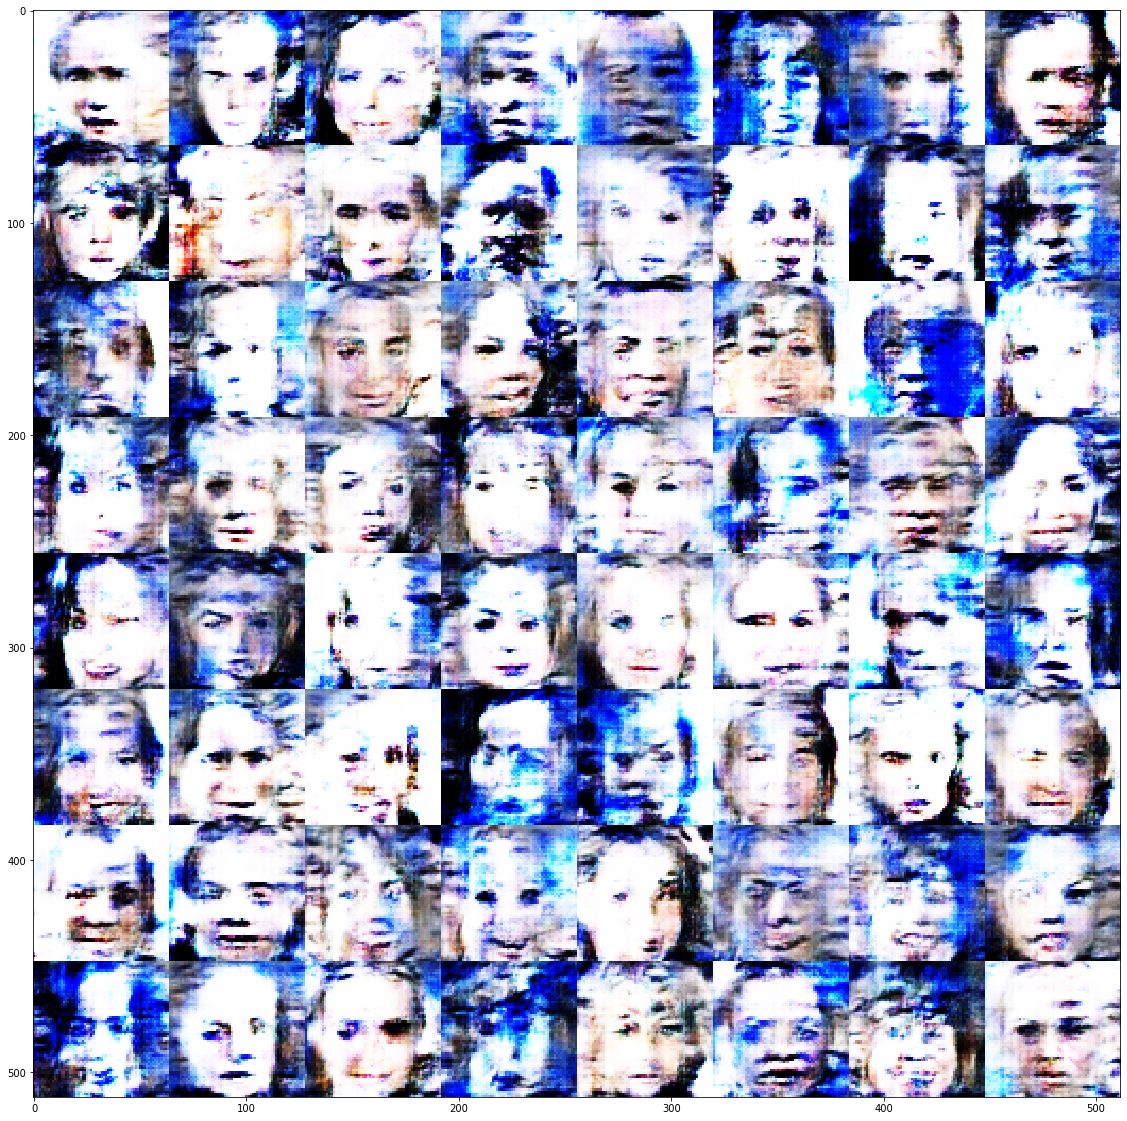

In [26]:
import matplotlib.image as mpimg

def show_image(filename, sample_dir = 'sample_faces'):
    plt.figure(figsize=(20, 20))
    plt.imshow(mpimg.imread(os.path.join(sample_dir, filename)))

epoch = 1
idx = 3134
show_image('train_{:02d}_{:04d}.png'.format(epoch, idx))

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

We first generate two random images z1, and z2. We then interpolate their z using the smearing formula above using a uniformly distributed alpah between 0 and 1. We then look at images generated using z1 and z2 along with all the interpolated images. At alpha close to zero image looks like z2 as expected and gradually starts looking like z1 and at alpha close to1 becomes almost exactly like z1.

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


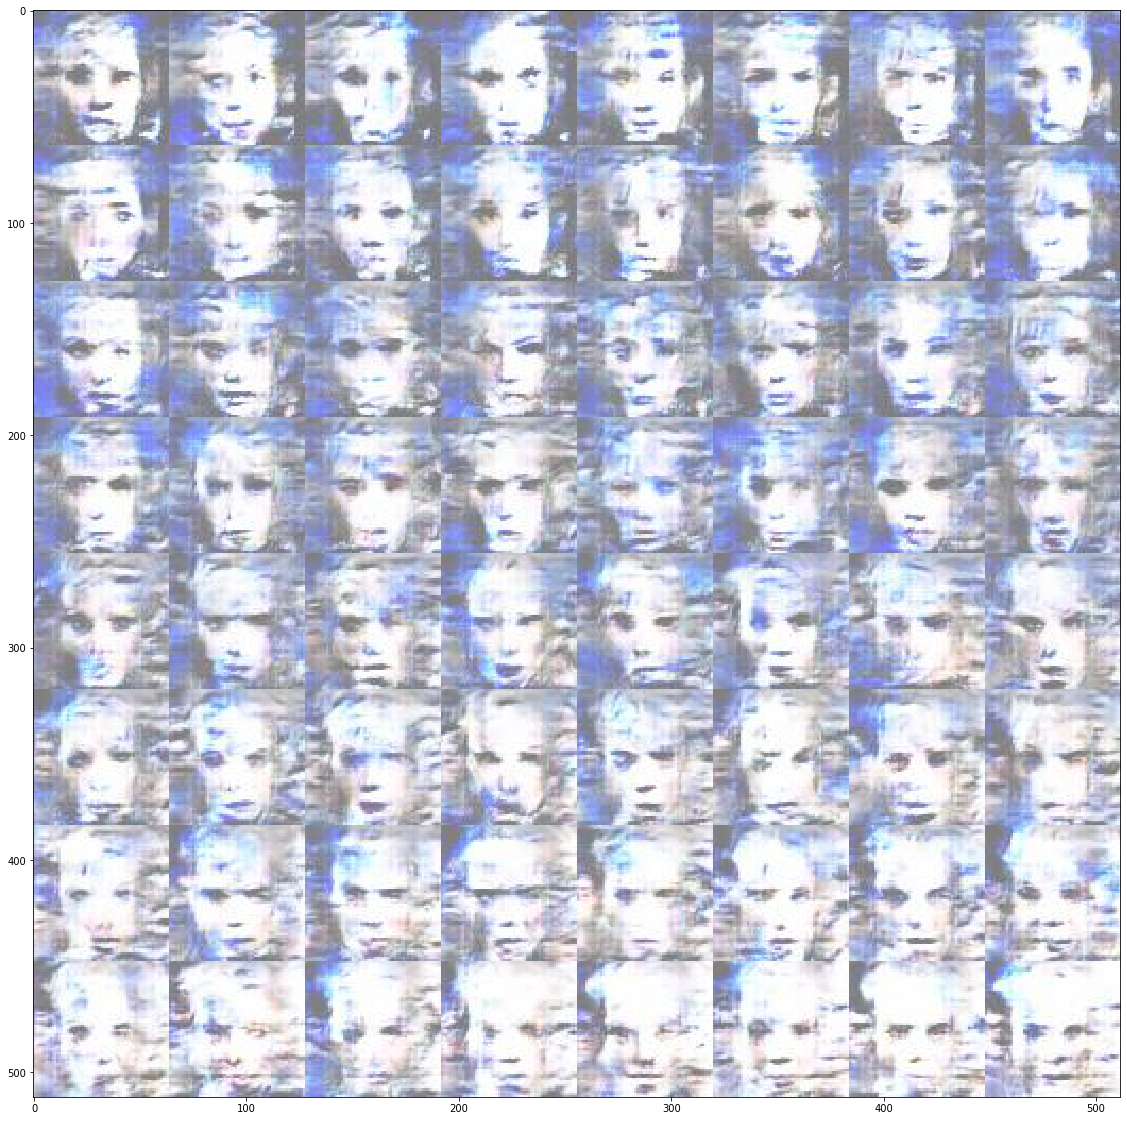

In [27]:
z1 = np.random.uniform(-1, 1, Z_DIM).astype(np.float32)
z2 = np.random.uniform(-1, 1, Z_DIM).astype(np.float32)
alphas = np.linspace(0, 1, num=BATCH_SIZE)
batchz = np.array([alpha*z1 + (1-alpha)*z2 for alpha in alphas])

with tf.compat.v1.Session() as sess:
    load(sess, load_dir="checkpoint")
    imgs = sess.run(G, feed_dict={z: batchz, is_training: False})
    imgs = inverse_transform(imgs)

save_images(imgs, [MERGE_X, MERGE_X],os.path.join('sample_faces', 'face_interpolation.jpg'))
show_image('face_interpolation.jpg')

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.


Here we generate some random images and pick some smiling and non-smiling ones manually.

In [29]:
#batchz = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
#samples = sess.run(G, feed_dict={z: batchz, is_training: False})
#plt.figure(figsize=(16, 48))
#for i, sample in enumerate(samples):
#    plt.subplot(16, 4, i+1)
#    plt.axis('off')
#    plt.title(str(i))
#    plt.imshow((255*inverse_transform(sample)).astype(np.uint8))
#plt.show()

Manually classify images with smile and without smile.

Here we take the mean of the smiling z vectors and that of the non-smiling ones. Then we calculate the difference as the smile vector and then apply that to the no smiling ones.

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


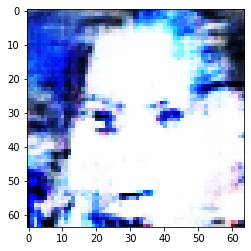

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


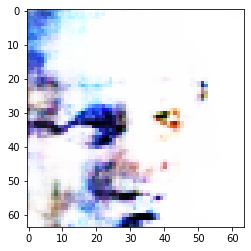

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


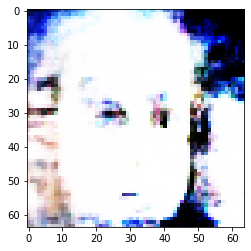

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


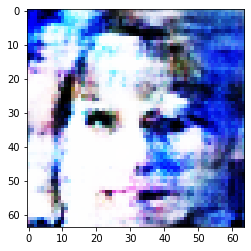

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) Y
Y
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


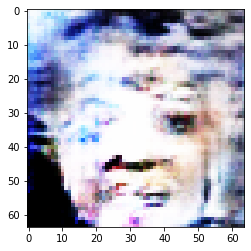

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


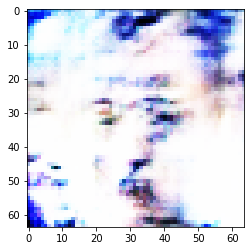

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


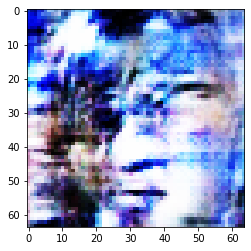

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


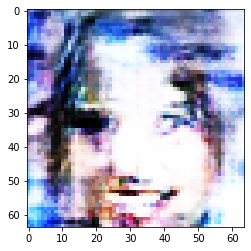

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) Y
Y
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


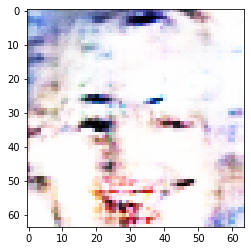

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) Y
Y
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


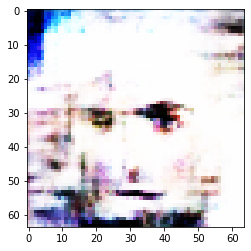

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


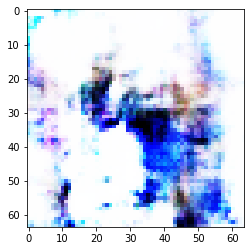

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


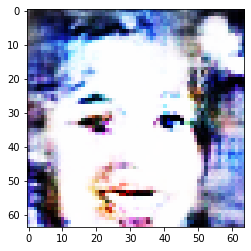

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) Y
Y
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


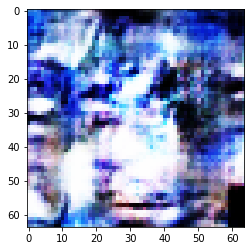

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


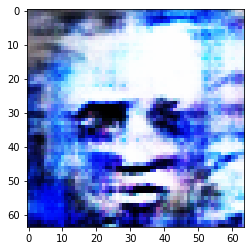

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


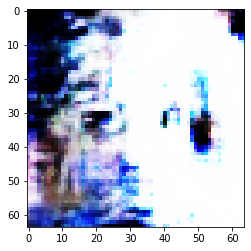

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


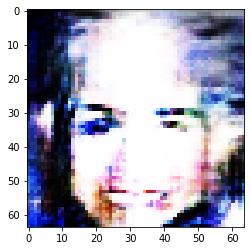

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) Y
Y
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


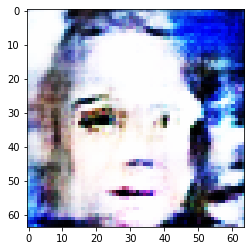

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


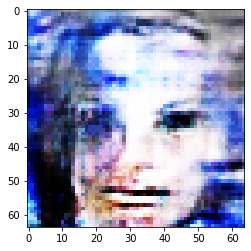

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


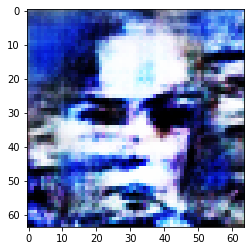

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


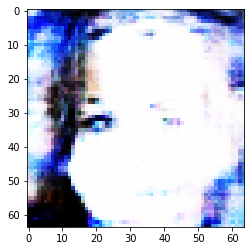

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) N
N
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


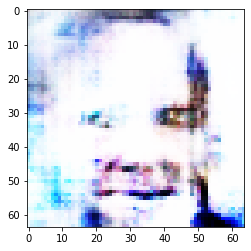

Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) Y
Y


In [30]:
smile = []
no_smile = []

while (len(smile) < 6) or (len(no_smile) < 6):
    z0 = np.random.uniform(-1, 1, Z_DIM).astype(np.float32)

    with tf.compat.v1.Session() as sess:
        load(sess, load_dir="checkpoint")
        batchz = np.array([z0 for i in range(BATCH_SIZE)])
        imgs = sess.run(G, feed_dict={z: batchz, is_training: False})

    imgs = inverse_transform(imgs)
    
    plt.imshow(imgs[0])
    plt.show(block=False)
    
    k = input("Smiling or not? (Y=Yes, N=No, S=Skip, Q=Quit) ")
    print(k.upper())
    
    if k.upper() == 'Y':
        smile.append(z0)
    elif k.upper() == 'N':
        no_smile.append(z0)
    elif k.upper() == 'Q':
        break

In [31]:
with open('smiles.npy', 'wb') as f:
    np.save(f, smile)
    np.save(f, no_smile)

with open('smiles.npy', 'rb') as f:
    smile = np.load(f)
    no_smile = np.load(f)

smile_vector =  np.mean(smile[:5]) - np.mean(no_smile[:5])

Finally we look at the original non-smiling images and the ones after adding smiling z-vector to their generative code.

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


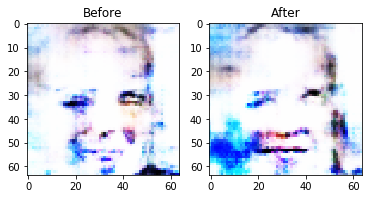

In [32]:
def get_image(z0):
    with tf.compat.v1.Session() as sess:
        load(sess, load_dir="checkpoint")
        batchz = np.array([z0 for i in range(BATCH_SIZE)])
        imgs = sess.run(G, feed_dict={z: batchz, is_training: False})

    imgs = inverse_transform(imgs)
    return imgs[0]

plt.subplot(121)
plt.imshow(get_image(smile[5]))
plt.title('Before');

plt.subplot(122)
plt.imshow(get_image(smile[5] + smile_vector))
plt.title('After');

If faces looks really cool, add bonus 1 point to your score.

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


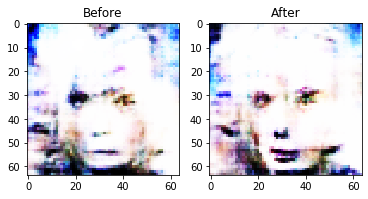

In [33]:
plt.subplot(121)
plt.imshow(get_image(no_smile[6]))
plt.title('Before');

plt.subplot(122)
plt.imshow(get_image(no_smile[6] + smile_vector))
plt.title('After');

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


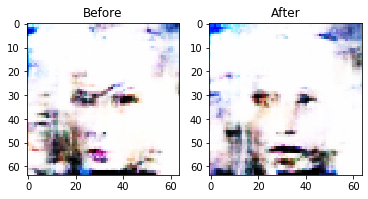

In [34]:
plt.subplot(121)
plt.imshow(get_image(no_smile[6]))
plt.title('Before');

plt.subplot(122)
plt.imshow(get_image(no_smile[6] + smile_vector))
plt.title('After');

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


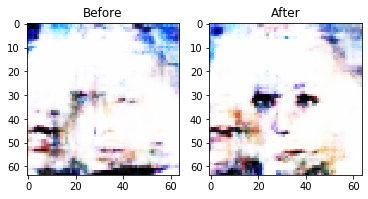

In [36]:
plt.subplot(121)
plt.imshow(get_image(no_smile[6]))
plt.title('Before');

plt.subplot(122)
plt.imshow(get_image(no_smile[6] + smile_vector))
plt.title('After');